# Coronavirus Insights

## Aim:

1. To identify the **Risk Factors**, i.e., the factors which make the affect of coronavirus more likely in a person based on certain medical or social conditions
2. To determine the **Transmission Factors**, i.e., the factors which make the spread of coronavirus more likely
3. To look for the **Affected Organs** due to corona virus apart from the more commonly known 'lungs'

## Table of Contents: -

### 0.	LIBRARIES
    0.1	Downloading Libraries
    0.2	Importing Libraries
    0.3	Function Definition
### 1.	DATA PREPARATION
    1.1	Checking for missing values
    1.2	Data Cleaning
### 2.	SEARCHING LABELS
    2.1	Risk Factors
    2.2	Transmission Factors
    2.3	Affected Organs
### 3.	DATA EXPLORATION
    3.1	Frequency Related Visuals
    3.2	Reducing search labels
    3.3	Plotting with Reduced search labels
### 4.	EXPERIMENTING DIFFERENT DATAFRAMES MODEL OF RISK FACTORS LABELS FOR HEIRARCHICAL CLUSTERING
    4.1	Modified Bag of Ngrams using REGEX On Risk Factors (self developed)
    4.2	Using okapi BM25
    4.3	Using TFIDF – Vectorizer
### 5.	EXPERIMENTING DIFFERENT DATAFRAMES MODEL OF RISK FACTORS LABELS FOR KMEANS CLUSTERING
    5.1	Kmeans on Modified Bag of Ngrams using REGEX On Risk Factors (self developed)
    5.2	Kmeans on okapi BM25
    5.3	Kmeans on TFIDF – Vectorizer
### 6.	HIERARCHICAL CLUSTERING OF RISK FACTORS
### 7.	HIERARCHICAL CLUSTERING OF TRANSMISSION FACTORS
### 8.	HIERARCHICAL CLUSTERING OF AFFECTED ORGANS
### 9.	INSIGHTS AND RESULTS SUMMARY
    9.1	Summary of Coding Logic and Experimentation with Clustering
    9.2	Summary of Data Visualization and Inferred Results
        9.2.1	Risk Factors
        9.2.2	Transmission Factors
        9.2.3	Affected Organs


## References:

https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/people-at-higher-risk.html

https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/prevention-risks.html

https://www.vox.com/science-and-health/2020/4/8/21207269/covid-19-coronavirus-risk-factors

https://www.nbcnewyork.com/news/coronavirus/what-underlying-factors-put-people-at-higher-risk-for-severe-coronavirus-cases/2332144/

https://www.kff.org/global-health-policy/issue-brief/how-many-adults-are-at-risk-of-serious-illness-if-infected-with-coronavirus/

https://pypi.org/project/rank-bm25/


# 0. LIBRARIES ------------------------------------------------------------------------------------------

## 0.1 Downloading Libraries

In [ ]:
!pip install -U pip
!pip install -U dill
!pip install -U nltk==3.4
!pip install rank_bm25

Requirement already up-to-date: pip in c:\python\anaconda3\lib\site-packages (20.0.2)
Requirement already up-to-date: dill in c:\python\anaconda3\lib\site-packages (0.3.1.1)
Requirement already up-to-date: nltk==3.4 in c:\python\anaconda3\lib\site-packages (3.4)


## 0.2 Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import dateutil.parser as parser

import re
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

import string

from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\Gautam
[nltk_data]     Dawar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Gautam
[nltk_data]     Dawar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Gautam
[nltk_data]     Dawar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 0.3 Function Definition

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')         

def tokenize(text):
    '''
    APPLICATION:
    To tokenise a string based on white spaces
    
    INPUT:
    text = string to tokenize
    
    RETURN:
    text_tokenized = list of tokens
    
    '''
    
#     tweet_tokenized = tokenizer.tokenize(tweet)
    text_tokenized = text.split(' ')
    return text_tokenized

In [ ]:
def text_cleaner(text):
    '''
    APPLICATION:
    To perform text cleaning
    
    INPUT:
    text = string to clean
    
    RETURN:
    text_no_punct = cleaned string
    
    '''    
    #----- lowercasing----------------------------------------------------------------------------------------------
    text_lower = text.lower()
      
    #----- Punctuation removal ----------------------------------------------------------------------------------------------
    text_lower = re.sub(r"/+|-+", " ", text_lower)
    text_lower = re.sub(r"abstract\B", " ", text_lower) # removing 'abstract' from the staring of each abstract entry
    to_remove = string.punctuation + '\n'
    text_no_punct  = "".join([char for char in text_lower if char not in to_remove]) #removing punctuation marks
#     text_no_punct = re.sub('[0-9]+', '', text_no_punct) # removing all number from 0 to 9

    #----- tokenizing----------------------------------------------------------------------------------------------
    text_no_punct = tokenize(text_no_punct)
    
    #----- stop words removal ----------------------------------------------------------------------------------------------
    stopword = nltk.corpus.stopwords.words('english')
    stopword = list(set(stopword))
    text_no_punct = [word for word in text_no_punct if word not in stopword] # remove stop words

    #----- Lemmatizing ----------------------------------------------------------------------------------------------
    lemmatize = WordNetLemmatizer()
    text_no_punct = [lemmatize.lemmatize(word) for word in text_no_punct]
    
    #----- Detokenizing ----------------------------------------------------------------------------------------------
    text_no_punct = ' '.join(text_no_punct)

    return text_no_punct

In [ ]:
def regex_ngram_search(risk_factors, df_papers, search_column = 'title_abstract_merged_cleaned'):
    '''
    APPLICATION:
    To perform ngram search on all the documents (working discussed in Section 2.1)
    
    INPUT:
    risk_factors = list of labels to search
    df_papers = dataframe to apply the search on
    search_column = the column in the datafame to apply the search on
    
    RETURN:
    risk_factor_count_num = pd series of count of each word
    
    ''' 
    
    #----- (working discussed in Section 2.1) ----------------------------------------------------------------------------------------------
    risk_factor_count_dict = {}

    for i in risk_factors:
        query_tokens = tokenize(i)

        if len(query_tokens) == 1: # if the label is a unigram then use this code
            list_temp = df_papers[df_papers[search_column].str.contains(' '+ query_tokens[0] +' ')].index.to_list() #using string contains function of pandas to search for the tokens
            risk_factor_count_dict[i] = list_temp

        elif len(query_tokens) == 2: # if the label is a bigram then use this code
            list_temp = df_papers[df_papers[search_column].str.contains(' '+ query_tokens[0] +' ')].index.to_list()
            list_temp1 = df_papers[df_papers[search_column].str.contains(' '+ query_tokens[1] +' ')].index.to_list()
            risk_factor_count_dict[i] = list(set(list_temp) & set(list_temp1))

        elif len(query_tokens) == 3: # if the label is a trigram then use this code
            list_temp = df_papers[df_papers[search_column].str.contains(' '+ query_tokens[0] +' ')].index.to_list()
            list_temp1 = df_papers[df_papers[search_column].str.contains(' '+ query_tokens[1] +' ')].index.to_list()
            list_temp2 = df_papers[df_papers[search_column].str.contains(' '+ query_tokens[2] +' ')].index.to_list()
            risk_factor_count_dict[i] = list(set(list_temp) & set(list_temp1) & set(list_temp2))

        list_temp = []
        list_temp1 = []
        list_temp2 = []

    #----- creating a copy of the dictionary -------------------------------------------------------------------------------------
    risk_factor_count_num = risk_factor_count_dict.copy()

    #----- getting the length of the list of indexes which would serve as total appearance of that term in the document ----------
    risk_factor_count_num.update((x, len(y)) for x, y in risk_factor_count_num.items())

    #----- sorting the created dictionary of word count --------------------------------------------------------------------------
    risk_factor_count_num = pd.Series(risk_factor_count_num).sort_values(ascending=False)
    
    return risk_factor_count_num

In [ ]:
def regex_ngram_term_frequency(risk_factor_count_num_cutoff, df_papers, search_column = 'title_abstract_merged_cleaned'):
    '''
    APPLICATION:
    To perform dataframe creation of frequency of ngram in all the documents (working discussed in Section 4.1)
    
    INPUT:
    risk_factor_count_num_cutoff = pd series of count of each word
    df_papers = dataframe to apply the search on
    search_column = the column in the datafame to apply the search on
    
    RETURN:
    risk_factors_tf_df = dataframe of label frequency
    
    ''' 
    
    #----- (working discussed in Section 4.1) ---------------------------------------------------------------------------------
    risk_factors_tf = {} # define an empty dictionary

    for i in risk_factor_count_num_cutoff.index:
        query_tokens = tokenize(i) 
        freq_tracker = []

        if len(query_tokens) == 1: # if the label is a unigram then use this code
            for j in df_papers[search_column].values:
                abstract_length = len(re.findall(r'\w+',j)) #using re.findall function of pandas to search for the tokens
                temp = len(re.findall(r' '+query_tokens[0]+' ',j))
                frequency = temp/abstract_length
                freq_tracker.append(frequency)

        elif len(query_tokens) == 2: # if the label is a bigram then use this code
            for j in df_papers[search_column].values:
                abstract_length = len(re.findall(r'\w+',j))
                temp = len(re.findall(r' '+query_tokens[0]+' ',j))
                temp1 = len(re.findall(r' '+query_tokens[1]+' ',j))
                frequency = (temp+temp1)/abstract_length
                freq_tracker.append(frequency)

        elif len(query_tokens) == 3: # if the label is a trigram then use this code
            for j in df_papers[search_column].values:
                abstract_length = len(re.findall(r'\w+',j))
                temp = len(re.findall(r' '+query_tokens[0]+' ',j))
                temp1 = len(re.findall(r' '+query_tokens[1]+' ',j))
                temp2 = len(re.findall(r' '+query_tokens[2]+' ',j))
                frequency = (temp+temp1+temp2)/abstract_length
                freq_tracker.append(frequency)      

        risk_factors_tf[i] = freq_tracker # append the vector otained of each label in a dictionary
        
    risk_factors_tf_df = pd.DataFrame.from_dict(risk_factors_tf) # convert the dictionary of vectors to a pandas dataframe
    
    return risk_factors_tf_df

In [ ]:
def heirarchical_clustering(risk_factors_tf_df, metric = 'cosine', cutoff_line = 1.45, 
                            title = 'Heirarchical Clustering of Risk Factors', xlabel = 'Cosine Distance', 
                            ylabel = 'Risk Factors'):
    '''
    APPLICATION:
    To perform Hierarchical clustering
    
    INPUT:
    risk_factors_tf_df = dataframe of label frequency
    metric = the metric to create the distance matrix on
    cutoff_line = the cutoff distance to consider clusters from
    title = title of the plot
    xlabel = xlabel of the plot
    ylabel = ylabel of the plot
    
    RETURN:
    plt = plot of dendograms
    risk_factor_cluster_regex_df = dataframe of created clusters w.r.t. labels
    
    '''  
    
    dist2 = pairwise_distances(risk_factors_tf_df.T, metric = metric)

    linkage_matrix = ward(dist2) #define the linkage_matrix using ward clustering pre-computed distances

    fig, ax = plt.subplots(figsize=(15, 8)) # set size
    ax = dendrogram(linkage_matrix, orientation="right", labels = risk_factors_tf_df.T.index);
    plt.axvline(x=cutoff_line, c='k')
    plt.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')

    plt.title(title, fontsize = '25')
    plt.ylabel(ylabel, fontsize = '20')
    plt.xlabel(xlabel, fontsize = '20')
    plt.yticks(fontsize = '15')
    plt.tight_layout() #show plot with tight layout

    #----- Extracting the clusters using fcluster ------------------------------------------------------------------------------

    risk_factor_cluster_regex = fcluster(linkage_matrix, cutoff_line, criterion='distance')
    risk_factor_cluster_regex_df = pd.DataFrame()
    risk_factor_cluster_regex_df['label_name'] = risk_factors_tf_df.T.index
    risk_factor_cluster_regex_df['cluster_regex'] = risk_factor_cluster_regex
    
    return plt, risk_factor_cluster_regex_df

In [ ]:
def kmeans_clustering(risk_factors_tf_df, n_clusters=6):
    '''
    APPLICATION:
    To perform KMeans clustering
    
    INPUT:
    risk_factors_tf_df = dataframe of label frequency
    n_clusters = number of clusters to be created
    
    RETURN:
    risk_factor_cluster_regex_kmeans_df = dataframe of created KMeans clusters w.r.t. labels
    
    '''  
    
    risk_factor_cluster_regex_kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(risk_factors_tf_df.T)
    risk_factor_cluster_regex_kmeans_df = pd.DataFrame()
    risk_factor_cluster_regex_kmeans_df['label_name'] = risk_factors_tf_df.T.index
    risk_factor_cluster_regex_kmeans_df['cluster_regex'] = risk_factor_cluster_regex_kmeans.labels_
    
    return risk_factor_cluster_regex_kmeans_df

In [ ]:
def plot_barplot(x, y, 
                 title = 'Risk Factor Appearance in Research Papers', 
                 xlabel = 'Risk Factors', 
                 ylabel = 'Appearance in Research Paper', 
                 figsize=(20,10), t_size = 30, x_size = 20, y_size = 20, xticks_size = 15):
    '''
    APPLICATION:
    To create a bar plot
    
    INPUT:
    x = dataframe of x labels
    y = dataframe of y labels
    
    RETURN:
    barplot
    
    ''' 
    
    #----- Risk Factor Appearance in Research Papers -------------------------------------------------------------------------

    plt.figure(figsize=figsize)
    sns.barplot(x = x, y = y)
    plt.xticks(rotation = 'vertical', fontsize = xticks_size)
    plt.xlabel(xlabel, fontsize = x_size)
    plt.ylabel(ylabel, fontsize = y_size)
    plt.title(title, fontsize = t_size)

    #----- Adding labels -------------------------------------------------------------------------------------
    for x1,y1 in zip(np.arange(0,len(x),1), y):
        label = "{:.0f}".format(y1)
        plt.annotate(label, # this is the text
                     (x1,y1), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    plt.show()

# 1. DATA PREPARATION ----------------------------------------------------------------------------


### References for labels:

https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/people-at-higher-risk.html

https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/prevention-risks.html

https://www.vox.com/science-and-health/2020/4/8/21207269/covid-19-coronavirus-risk-factors

https://www.nbcnewyork.com/news/coronavirus/what-underlying-factors-put-people-at-higher-risk-for-severe-coronavirus-cases/2332144/

https://www.kff.org/global-health-policy/issue-brief/how-many-adults-are-at-risk-of-serious-illness-if-infected-with-coronavirus/

https://en.wikipedia.org/wiki/List_of_organs_of_the_human_body

In [ ]:
#----defining key words based on internet research and manual scraping of a few research paper abstracts -----------------------

virus_ref = ['covid-19', 'coronavirus', 'cov-2', 'sars-cov-2', 'sars-cov', 'hcov', '2019-ncov', 'corona']

organs = ['mouth','teeth','tongue','salivary gland','parotid gland','submandibular gland','sublingual gland',
          'pharynx','esophagus','stomach','small intestine','duodenum','jejunum','ileum','large intestine','liver',
          'gallbladder','mesentery','pancreas','anal canal', 'anus','blood cells','respiratory system','nasal cavity',
          'pharynx','larynx','trachea','bronchi','lung','diaphragm','urinary system','kidney','ureter','bladder','urethra',
          'reproductive organ','ovaries','fallopian tube','uterus','vagina','vulva','clitoris','placenta','testes',
          'epididymis','vas deferen','seminal vesicle','prostate','bulbourethral gland','penis','scrotum',
          'endocrine system','pituitary gland','pineal gland','thyroid gland','parathyroid glands','adrenal gland',
          'pancreas','circulatory system','heart','patent foramen ovale','arteries','veins','capillaries','lymphatic system',
          'lymphatic vessel','lymph node','bone marrow','thymus','spleen','tonsils','interstitium','nervous system',
          'brain','cerebrum','cerebral hemispheres','diencephalon','the brainstem','midbrain','pons','medulla oblongata',
          'cerebellum','the spinal cord','the ventricular system','choroid plexus','peripheral nervous system','nerves',
          'cranial nerves','spinal nerves','ganglia','enteric nervous system','sensory organs','eye','cornea','iris',
          'ciliary body','lens','retina','ear','outer ear','earlobe','eardrum','middle ear','ossicles','inner ear',
          'cochlea','vestibule of the ear','semicircular canals','olfactory epithelium','tongue','taste buds',
          'integumentary system','mammary glands','skin','subcutaneous tissue']
organs = list(set(organs)) # taking set to avoid duplicates

transmission_list = ['direct contact', 'close contact', 'indirect contact', 'person contact','air', 
                     'airborne', 'aerosol', 'respiratory route','respiratory droplet', 
                     'droplet', 'respiratory secretion', 'fomite', 'surface transmission', 'environmental surface', 'environment', 
                     'human transmission','patient transmission', 'fecaloral', 'faecaloral', 'mouth', 'hand transmission']
transmission_list = list(set(transmission_list)) # taking set to avoid duplicates


risk_factors = ['ageing', 'alcohol', 'concussion', 'cerebral hypoperfusion', 'diabetes', 'homocysteine', 
                'hypercholesterolaemia', 'hypertension', 'obesity', 'pesticides', 'pollution', 'physical inactivity', 
                'sleep disruption', 'smoking', 'neutrophil lymphocyte ratio', 'nlr', 'kidney impairment', 'hematuria', 
                'proteinuria', 'hypertension', 'diabetes', 'asthma', 'respiratory tract infection', 'empyema', 'lung cancer', 
                'tuberculosis', 'hiv', 'cerebrovascular disease', 'renal disease', 'liver disease', 'high blood pressure', 
                'weak immune', 'weak immunity', 'nursing home', 'disability care', 'copd', 'pulmonary disease', 'chemotherapy', 
                'radiotherapy', 'pregnant', 'comorbidities', 'lung cancer', 'heart disease', 'chronic bronchitis', 
                'cerebral infarction', 'copd', 'age 60', 'age 70', 'age 50', 'old age', 'care facility']
risk_factors = list(set(risk_factors)) # taking set to avoid duplicates

In [ ]:
#-----load the meta data from the CSV file --------------------------------------------------------------------------------------------------------------------------
df=pd.read_csv('metadata.csv', usecols=['title','abstract','authors','doi','publish_time'])
print ('shape of df BEFORE initial cleaning = ', df.shape)

#-----drop duplicates--------------------------------------------------------------------------------------------------------------------------
df = df.drop_duplicates(subset='abstract', keep="first")

#-----drop NANs --------------------------------------------------------------------------------------------------------------------------
df=df.dropna()

#-----convert abstracts to lowercase--------------------------------------------------------------------------------------------------------------------------
df["abstract"] = df["abstract"].str.lower()

print ('shape of df AFTER initial cleaning = ',df.shape)

shape of df BEFORE initial cleaning =  (45774, 5)
shape of df AFTER initial cleaning =  (34809, 5)


## 1.1 Checking for missing values

authors         0
publish_time    0
abstract        0
doi             0
title           0
dtype: int64


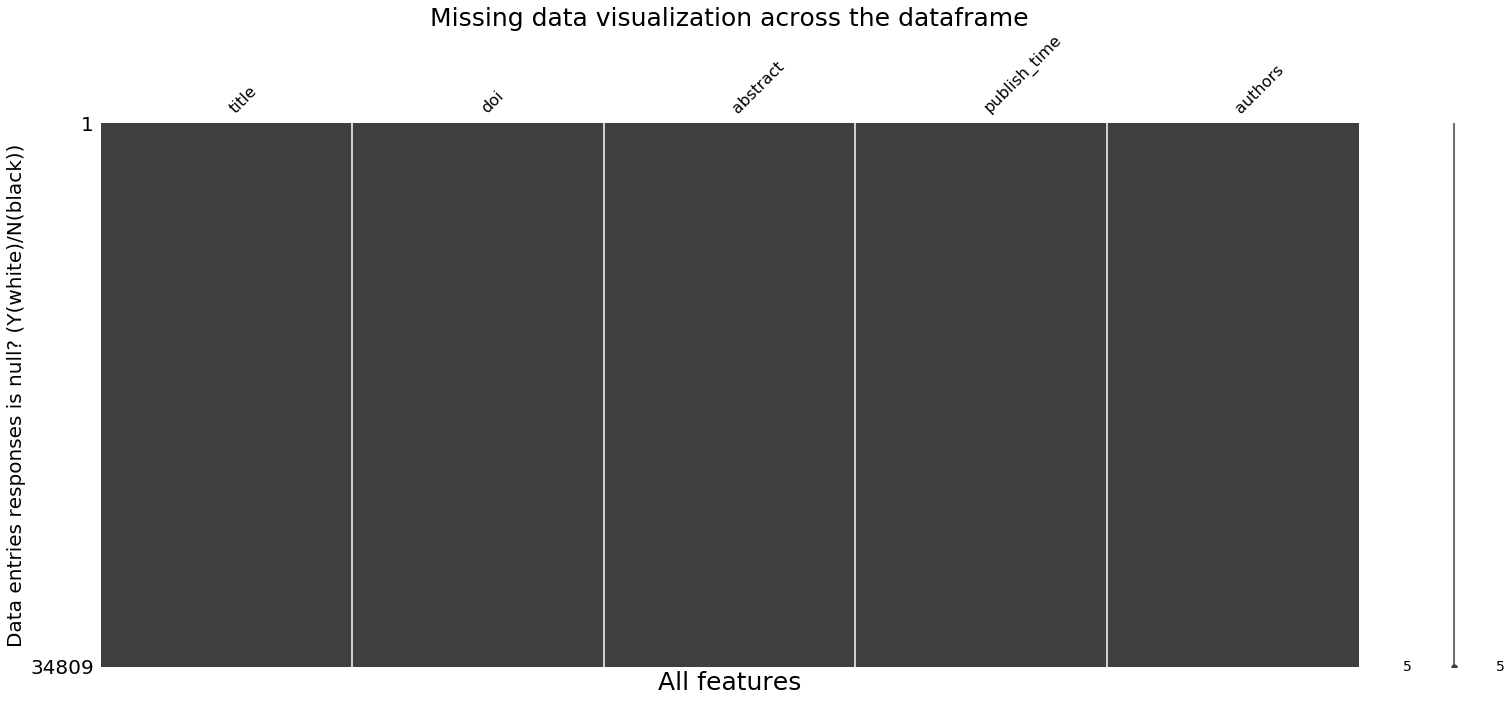

In [ ]:
##----- checking for null values --------------------------------------------------------------------------------------------------------------------------
ax = msno.matrix(df)
ax.set_xlabel('All features', Fontsize = 25)
ax.set_ylabel('Data entries responses is null? (Y(white)/N(black))', Fontsize = 20)
ax.set_title('Missing data visualization across the dataframe', Fontsize = 25)

##----- checking missing values in each features --------------------------------------------------------------------------------------------------------------------------
missing_value_count = df.isna().sum().sort_values(ascending=False)
print(missing_value_count) #type = pandas series

### Observation:

The verticle line on the extreme right shows the row-wise plot of the null values. As we can see, there are no null values. Hence proceeding with data cleaning

## 1.2 Data Cleaning

lowercasing, punctuation removal, stop words removal, lemmatizing, merging title with abstract so as to get better data insights

In [ ]:
#----- creating a copy of the dataframe -------------------------------------------------------------------------------------
df_papers = df.copy()

#----- Merging the title and the abstract to get broaden the search parameter -----------------------------------------------
df_papers['title_abstract_merged'] = df_papers['title'] + df_papers['abstract']

#----- Creating year publish column -----------------------------------------------
df_papers['publish_year'] = df_papers['publish_time'].apply(lambda x: parser.parse(x).year)

#----- cleaning the resultant feature -------------------------------------------------------------------------------------
df_papers['title_abstract_merged_cleaned'] = df_papers['title_abstract_merged'].apply(lambda x: text_cleaner(x))

In [ ]:
df_papers.head(3)

,title,doi,abstract,publish_time,authors,title_abstract_merged,publish_year,title_abstract_merged_cleaned
0,SIANN: Strain Identification by Alignment to N...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,SIANN: Strain Identification by Alignment to N...,2014,siann strain identification alignment near nei...
1,Spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,Spatial epidemiology of networked metapopulati...,2014,spatial epidemiology networked metapopulation ...
2,Sequencing of the human IG light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,Sequencing of the human IG light chain loci fr...,2014,sequencing human ig light chain locus hydatidi...


# 2. SEARCHING LABELS ---------------------------------------------------------------------------
### using NGRAMS and REGEX in PANDAS (self developed)

#### WORKING:

- The model created will tokenize each Ngram labels into tokens, and would use str.contains REGEX function of Pandas to search each token separately.
- The intersection of the 2 or more sets obatined after the step above will be taken and the list of all the common indexs' of each token search of a label will be stored in a list and appended to a dictionary
- The length of the list would be calculated so as to determine the number of appearance of that ngram label across the research paper database

#### OUTPUT:

Labels count, whose each token have appeared in the same context irrespective of the order of usage. This will assure that the label is not missed just because each tokens of the label didn't appear in the research paper in a particular order.

Also, this method would indicate that the selected abstract context is about the labels since the abstract contains all the token of the labels (irrespective of the order)

### NOTE: The full function has been modelled in Section 0 to keep the code concise with the name regex_ngram_search()

## 2.1 Risk Factors

In [ ]:
risk_factor_count_num = regex_ngram_search(risk_factors, df_papers, search_column = 'title_abstract_merged_cleaned')

In [ ]:
risk_factor_count_num.head()

respiratory tract infection    1465
hiv                            1207
pulmonary disease               629
asthma                          423
tuberculosis                    360
dtype: int64

## 2.2 Transmission Factors

In [ ]:
transmission_count_num = regex_ngram_search(transmission_list, df_papers, search_column = 'title_abstract_merged_cleaned')

In [ ]:
transmission_count_num.head()

human transmission      1232
environment             1228
patient transmission     705
air                      682
airborne                 301
dtype: int64

## 2.3 Affected Organs

In [ ]:
organs_count_num = regex_ngram_search(organs, df_papers, search_column = 'title_abstract_merged_cleaned')

In [ ]:
organs_count_num.head()

lung                  1987
respiratory system    1099
liver                  808
brain                  782
kidney                 674
dtype: int64

# 3. DATA EXPLORATION ----------------------------------------------------------------------------

## 3.1 Frequency Related Visuals

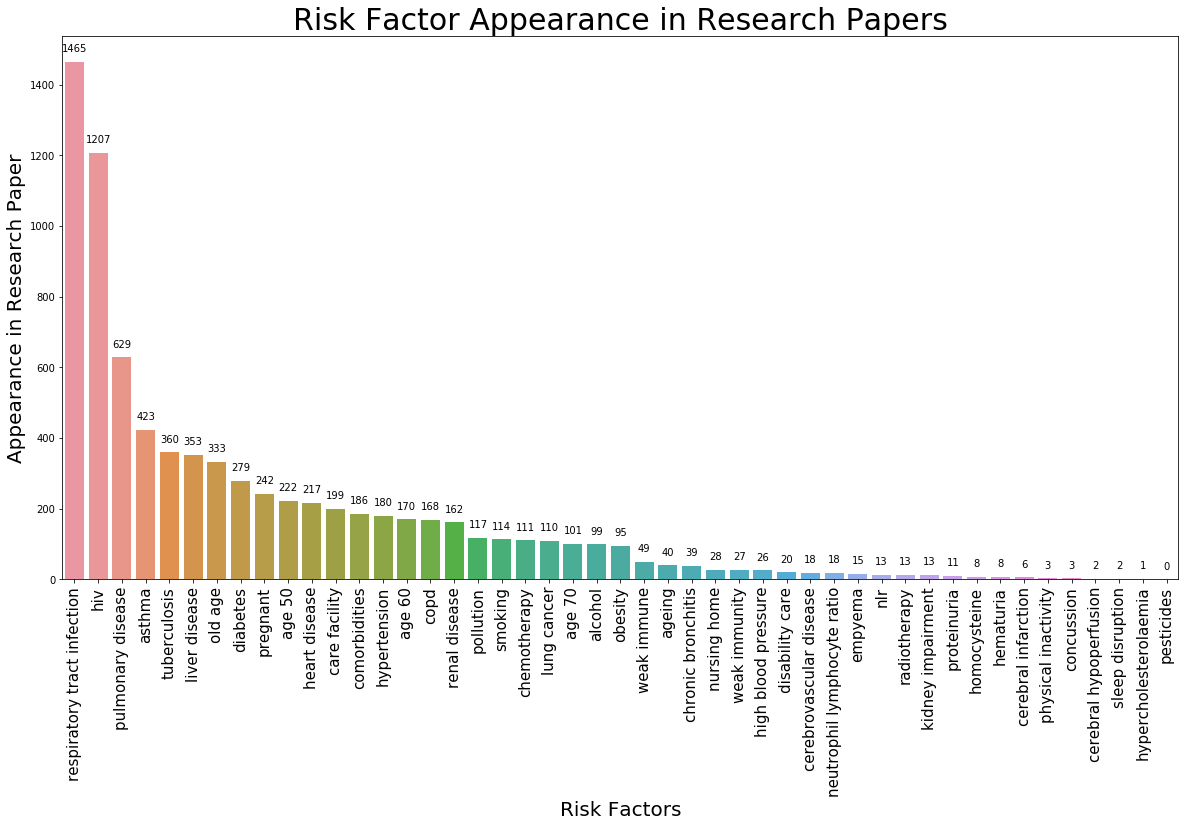

In [ ]:
plot_barplot(x = risk_factor_count_num.index, y = risk_factor_count_num.values, 
                 title = 'Risk Factor Appearance in Research Papers', 
                 xlabel = 'Risk Factors', 
                 ylabel = 'Appearance in Research Paper', 
                 figsize=(20,10))

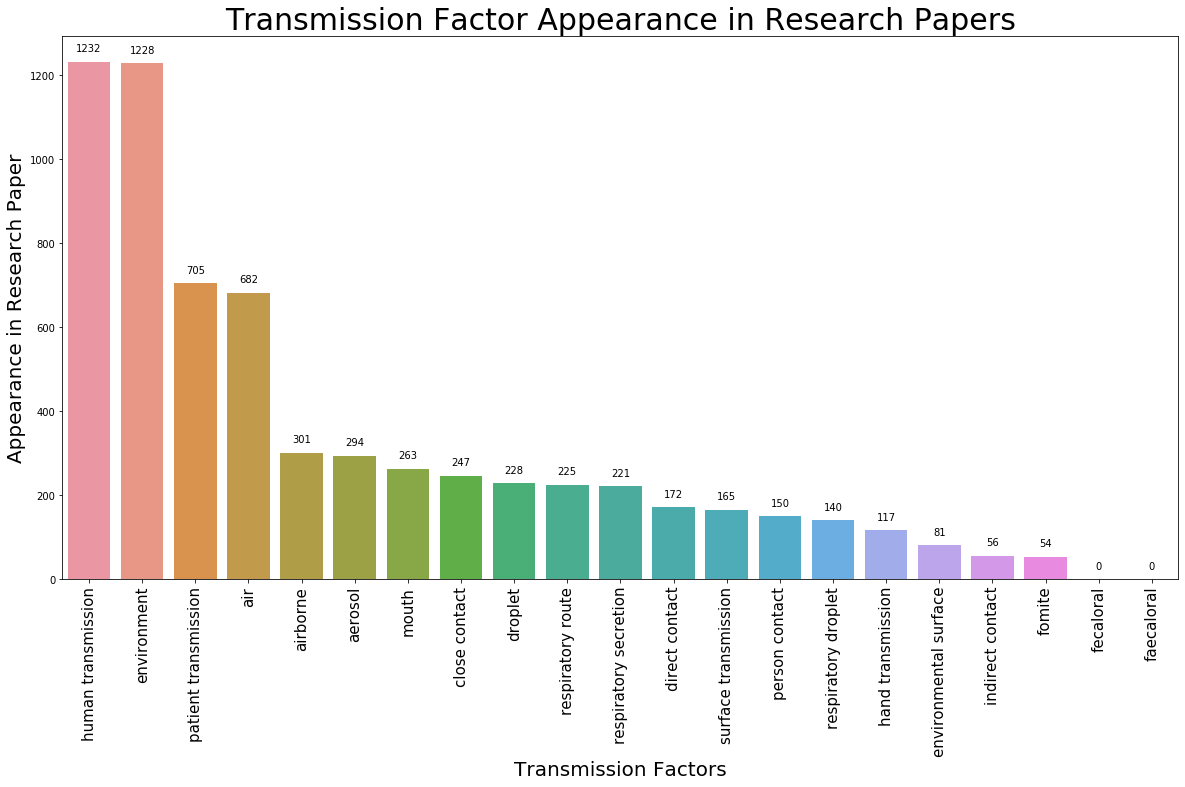

In [ ]:
plot_barplot(x = transmission_count_num.index, y = transmission_count_num.values, 
                 title = 'Transmission Factor Appearance in Research Papers', 
                 xlabel = 'Transmission Factors', 
                 ylabel = 'Appearance in Research Paper', 
                 figsize=(20,10))

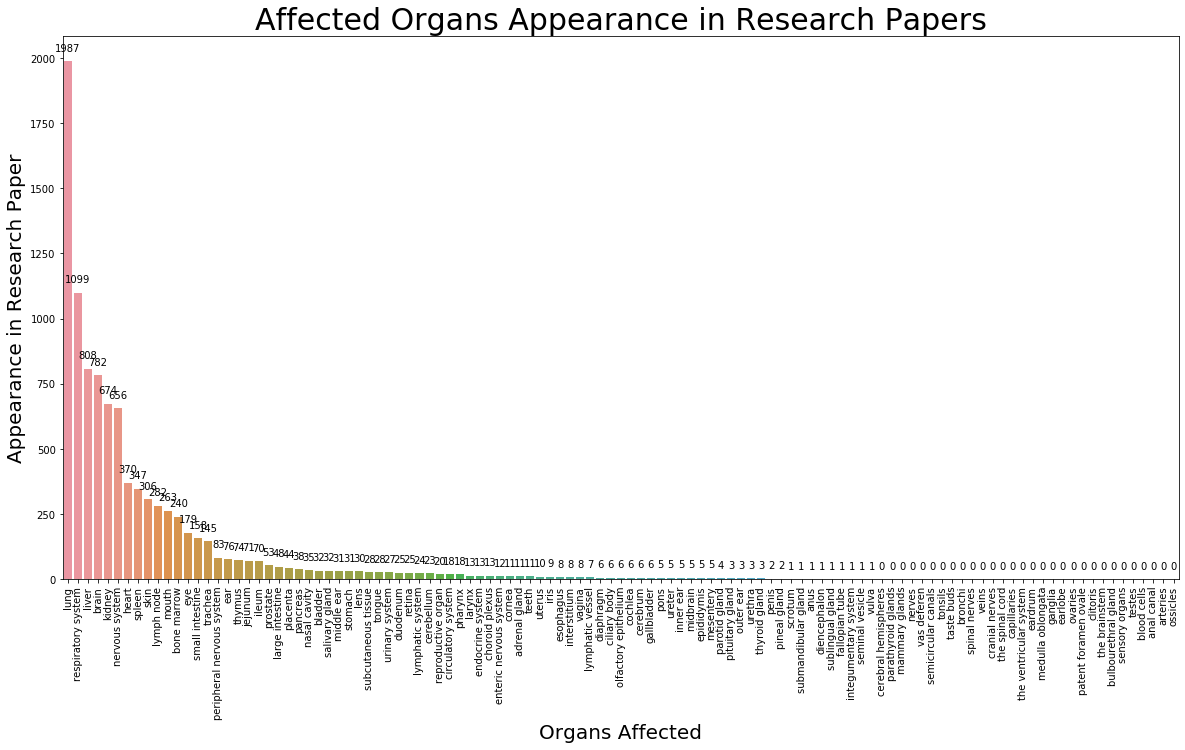

In [ ]:
plot_barplot(x = organs_count_num.index, y = organs_count_num.values, 
                 title = 'Affected Organs Appearance in Research Papers', 
                 xlabel = 'Organs Affected', 
                 ylabel = 'Appearance in Research Paper', 
                 figsize=(20,10), t_size = 30, x_size = 20, y_size = 20, xticks_size = 10)

## 3.2 Reducing search labels

We are getting few labels in Risk Factors and Transmission Factors as 0 or a very low value out of 35k reasearch papers. In order to save our clustering from such outliers, we will take a cutoff limit of 100, i.e. selecting the labels which appeared in more than 100 research papers

In [ ]:
cutoff_labels = 100

#----- Risk Factor Appearance in Research Papers -------------------------------------------------------------------------------
risk_factor_count_num_cutoff = risk_factor_count_num[risk_factor_count_num.values >= 100]

#----- Transmission Factor Appearance in Research Papers -----------------------------------------------------------------------
transmission_count_num_cutoff = transmission_count_num[transmission_count_num.values >= 100]

#----- Affected Organs Appearance in Research Papers ---------------------------------------------------------------------------
organs_count_num_cutoff = organs_count_num[organs_count_num.values >= 100]

## 3.3 Plotting with Reduced search labels

### Risk Factors

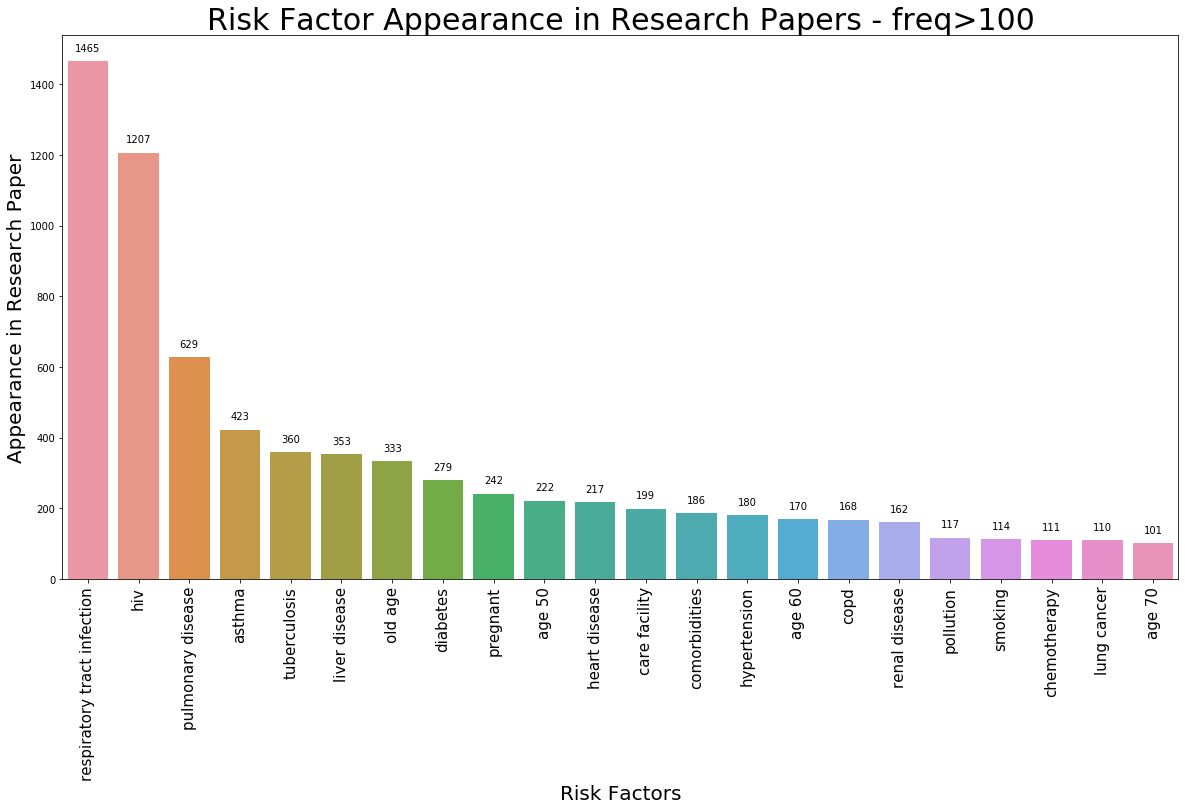

In [ ]:
plot_barplot(x = risk_factor_count_num_cutoff.index, y = risk_factor_count_num_cutoff.values, 
                 title = 'Risk Factor Appearance in Research Papers - freq>100', 
                 xlabel = 'Risk Factors', 
                 ylabel = 'Appearance in Research Paper', 
                 figsize=(20,10), t_size = 30, x_size = 20, y_size = 20, xticks_size = 15)

In [ ]:
#----- Selecting top 2 risk factors and creating time-series of its frequency using regex_ngram_search --------------------------------------------

first_risk_factor_dict = {}
second_risk_factor_dict = {}

for i in df_papers['publish_year'].unique():
    time_df = df_papers[df_papers['publish_year'] == i]
    first_risk_factor_dict[i] = int(regex_ngram_search([risk_factor_count_num_cutoff.index[0]], time_df, search_column = 'title_abstract_merged_cleaned').values)
    second_risk_factor_dict[i] = int(regex_ngram_search([risk_factor_count_num_cutoff.index[1]], time_df, search_column = 'title_abstract_merged_cleaned').values)
    
first_risk_factor_df = pd.DataFrame.from_dict(first_risk_factor_dict, orient = 'index').sort_index()
second_risk_factor_df = pd.DataFrame.from_dict(second_risk_factor_dict, orient = 'index').sort_index()

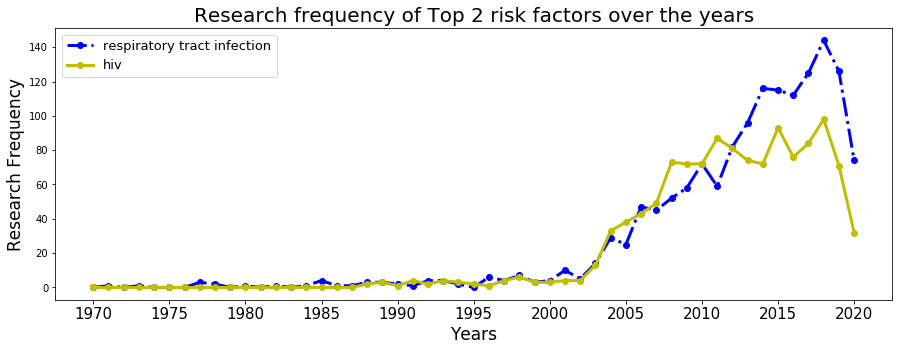

In [ ]:
#----- plotting the time series of top 2 risk factors -------------------------------------------------------------------------

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.subplot(1,1,1)
plt.plot(first_risk_factor_df.index, first_risk_factor_df.values, marker='o', color='b', linestyle='-.', linewidth=3, label = risk_factor_count_num_cutoff.index[0])
plt.plot(second_risk_factor_df.index, second_risk_factor_df.values,marker='o', color='y', linewidth=3, label = risk_factor_count_num_cutoff.index[1])
plt.xticks(np.arange(1970,2025,5), rotation=0, fontsize=15)
plt.xlabel('Years', fontsize=17)
plt.ylabel('Research Frequency', fontsize=17)
plt.title('Research frequency of Top 2 risk factors over the years', fontsize=20)

plt.legend(fontsize=13)
plt.show()

### Observation:

It seems that the **pre existing condition of respiratory track infection, HIV, Pulmonary Disease and Asthama** are the major risk factors discussed in the research papers related to coronaviruses. Hence people with these pre-existing condiotions **should be extra careful and under care during the corona virus pandemic**

Also, in **Risk Factor Time Series Graph**, it is evident that the research of the risk factors of HIV and Respiratory Track Infection **started growing after 2003**. The reson being, **2003 was hit by one of a kind SARS pandemic** which is similar to the current coronavirus pandemic in terms of symptoms. Hence the research post the 2003 pandemic increased in weak immunity and breathing based risk factors such as HIV and Respiratory Track Infection. 

### Transmission Factors

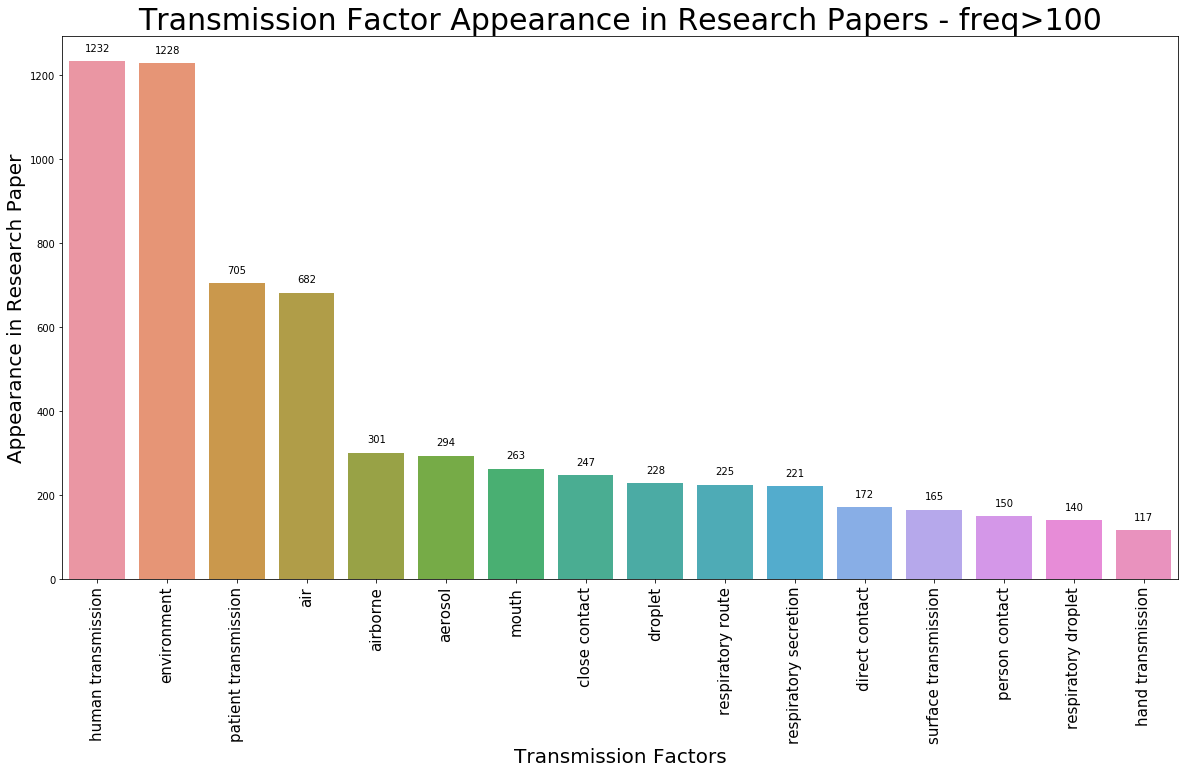

In [ ]:
plot_barplot(x = transmission_count_num_cutoff.index, y = transmission_count_num_cutoff.values, 
                 title = 'Transmission Factor Appearance in Research Papers - freq>100', 
                 xlabel = 'Transmission Factors', 
                 ylabel = 'Appearance in Research Paper', 
                 figsize=(20,10), t_size = 30, x_size = 20, y_size = 20, xticks_size = 15)

In [ ]:
#----- Selecting top 2 transmission factors and creating time-series of its frequency using regex_ngram_search --------------------------------------------

first_transmission_factor_dict = {}
second_transmission_factor_dict = {}

for i in df_papers['publish_year'].unique():
    time_df = df_papers[df_papers['publish_year'] == i]
    first_transmission_factor_dict[i] = int(regex_ngram_search([transmission_count_num_cutoff.index[0]], time_df, search_column = 'title_abstract_merged_cleaned').values)
    second_transmission_factor_dict[i] = int(regex_ngram_search([transmission_count_num_cutoff.index[1]], time_df, search_column = 'title_abstract_merged_cleaned').values)

first_transmission_factor_df = pd.DataFrame.from_dict(first_transmission_factor_dict, orient = 'index').sort_index()
second_transmission_factor_df = pd.DataFrame.from_dict(second_transmission_factor_dict, orient = 'index').sort_index()

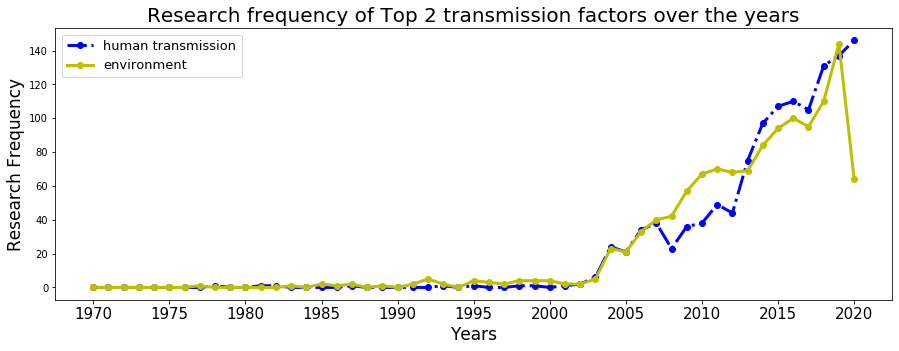

In [ ]:
#----- plotting the time series of top 2 transmission factors -------------------------------------------------------------------------

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.subplot(1,1,1)
plt.plot(first_transmission_factor_df.index, first_transmission_factor_df.values, marker='o', color='b', linestyle='-.', linewidth=3, label = transmission_count_num_cutoff.index[0])
plt.plot(second_transmission_factor_df.index, second_transmission_factor_df.values,marker='o', color='y', linewidth=3, label = transmission_count_num_cutoff.index[1])
plt.xticks(np.arange(1970,2025,5), rotation=0, fontsize=15)
plt.xlabel('Years', fontsize=17)
plt.ylabel('Research Frequency', fontsize=17)
plt.title('Research frequency of Top 2 transmission factors over the years', fontsize=20)

plt.legend(fontsize=13)
plt.show()

### Observation:

**Human Transmission, Patient Transmission and air** appear to be most potent to spread coronaviruses. Hence **social distancing** during the pandemic would be an effective option to curb the spread of coronaviruses through such means.

Also, in **Transmission Factor Time Series Graph**, it is evident that the research of the transmission factors of Human Transmission and Environment **started growing after 2003**. The reson being, **2003 was hit by one of a kind SARS pandemic which could be spread between human-human and human-environemt surfaces** which is similar to the current coronavirus pandemic. Hence the research post the 2003 pandemic increased in transmission factors.

Moreover, in **Transmission Factor Time Series Graph**, the research of Transmission Factors hit its peak in 2019, which saw the onset of the coronavirus pandemic

### Affected Organs

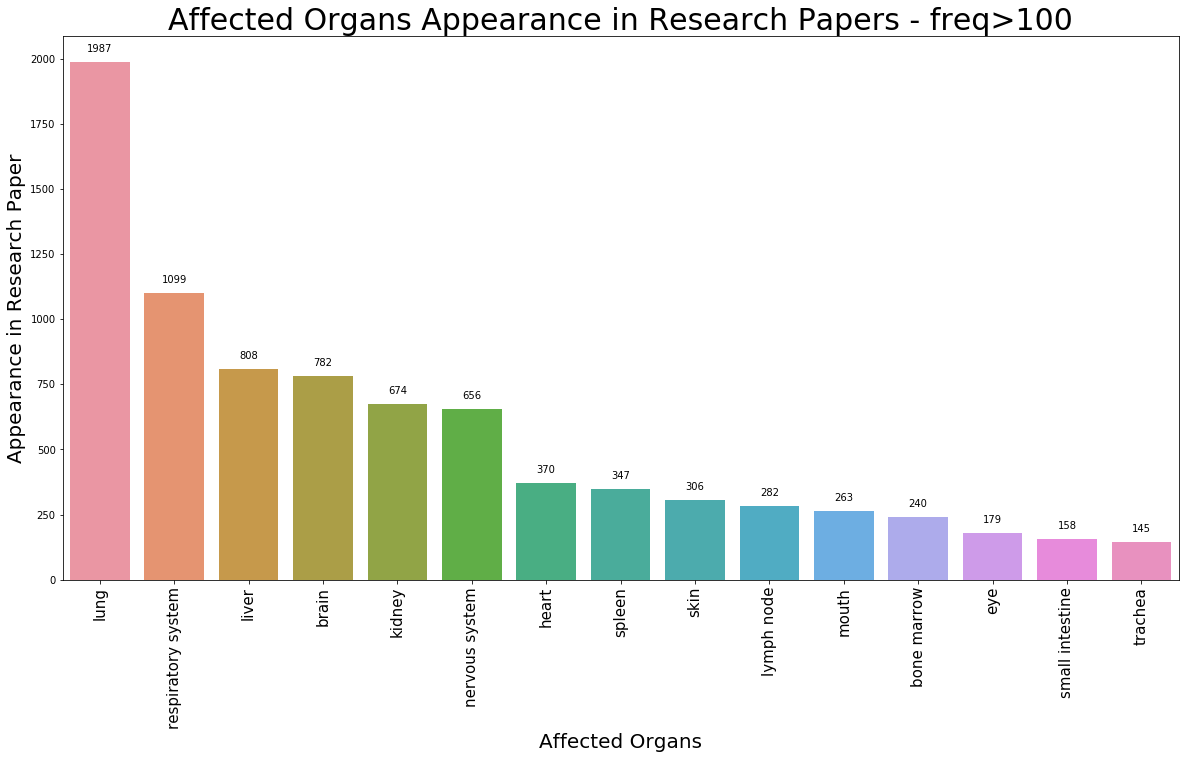

In [ ]:
plot_barplot(x = organs_count_num_cutoff.index, y = organs_count_num_cutoff.values, 
                 title = 'Affected Organs Appearance in Research Papers - freq>100', 
                 xlabel = 'Affected Organs', 
                 ylabel = 'Appearance in Research Paper', 
                 figsize=(20,10), t_size = 30, x_size = 20, y_size = 20, xticks_size = 15)

In [ ]:
#----- Selecting top 2 Organs and creating time-series of its frequency using regex_ngram_search --------------------------------------------

first_organ_dict = {}
second_organ_dict = {}

for i in df_papers['publish_year'].unique():
    time_df = df_papers[df_papers['publish_year'] == i]
    first_organ_dict[i] = int(regex_ngram_search([organs_count_num_cutoff.index[0]], time_df, search_column = 'title_abstract_merged_cleaned').values)
    second_organ_dict[i] = int(regex_ngram_search([organs_count_num_cutoff.index[2]], time_df, search_column = 'title_abstract_merged_cleaned').values)

first_organ_df = pd.DataFrame.from_dict(first_organ_dict, orient = 'index').sort_index()
second_organ_df = pd.DataFrame.from_dict(second_organ_dict, orient = 'index').sort_index()

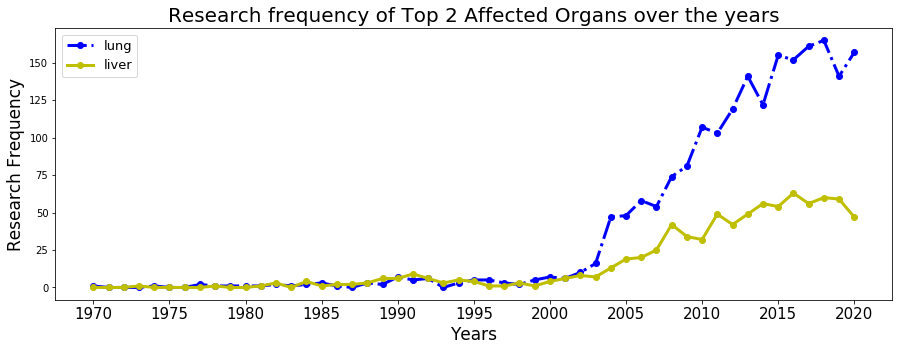

In [ ]:
#----- plotting the time series of top 2 affected organs -------------------------------------------------------------------------

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.subplot(1,1,1)
plt.plot(first_organ_df.index, first_organ_df.values, marker='o', color='b', linestyle='-.', linewidth=3, label = organs_count_num_cutoff.index[0])
plt.plot(second_organ_df.index, second_organ_df.values,marker='o', color='y', linewidth=3, label = organs_count_num_cutoff.index[2])
plt.xticks(np.arange(1970,2025,5), rotation=0, fontsize=15)
plt.xlabel('Years', fontsize=17)
plt.ylabel('Research Frequency', fontsize=17)
plt.title('Research frequency of Top 2 Affected Organs over the years', fontsize=20)

plt.legend(fontsize=13)
plt.show()

### Observation:

The coronaviruses seems to be affecting the **lungs, liver and kidney** the most. Hence care must be taken during organ transplant, **smoking and consumption of fried food and alcohol should be avoided** during this pandemic so as to avoid hampering the health of these organs

Also, in **Affected Organ Time Series Graph**, it is evident that the research of the transmission factors of affected lungs and liver **started growing after 2003**. The reson being, **2003 was hit by one of a kind SARS pandemic which could affect the Lungs and Liver siverely** which is similar to the current coronavirus pandemic. Hence the research post the 2003 pandemic increased in such affected organs.

# 4. EXPERIMENTING DIFFERENT DATAFRAMES MODEL OF RISK FACTORS LABELS FOR HEIRARCHICAL CLUSTERING -------------------------------------------------

## 4.1 Modified Bag of Ngrams using REGEX On Risk Factors (self developed)

#### WORKING:
- Each label with ngrams would be splitted into tokens
- Each token would be searched in each abstract to fetch a count of the appearance of the token in each abstract
- Each count of each tokens would be added
- The sum of each tokens appearance would then we divided by the total words in abstract (to normalise)

#### OUTPUT:
- This would give us combined frequency of the bag of words which is similar to coneventional bag of words frequency but has been modified to search for work tokens from the labels, which appear in any order in the text condsidered
- The vectors of each label obtained by this method would then be used for clustering.

### NOTE: The full function has been modelled in Section 0 to keep the code concise

#### Moreover, the abstract word distribution among all research papers has been visualised below:


--------------- Number of Outlier Abstracts with more than 500 words ------------------------
34

--------------- Percentage of Outlier Abstracts with more than 500 words ------------------------
0.098%


Text(0, 0.5, 'Density')

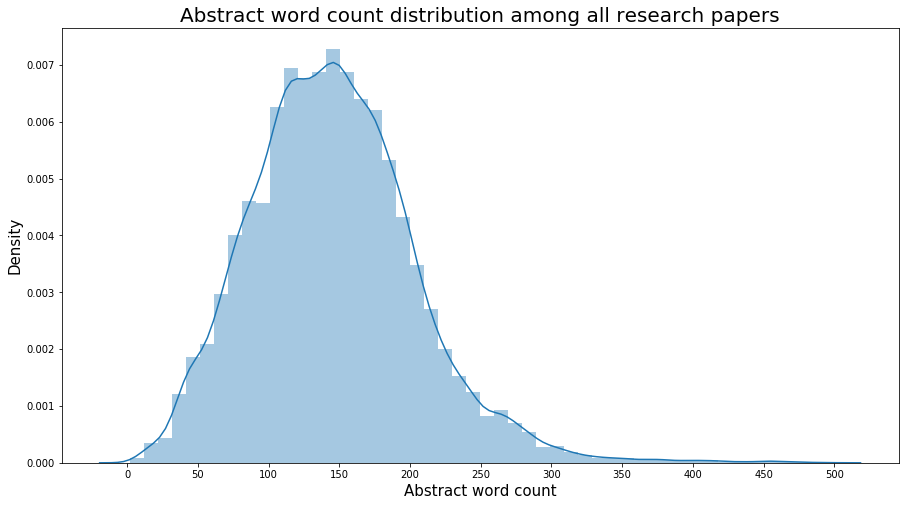

In [ ]:
#-----visualizing the abstract word count distribution of the dataframe -------------------------------------------------------------------------

abstract_word_count = []
for i in df_papers['title_abstract_merged_cleaned'].values:
    count = len(re.findall(r'\w+',i))
    abstract_word_count.append(count)
    
abstract_word_count_df = pd.Series(abstract_word_count)
abstract_word_count_df_no_outliers = abstract_word_count_df[abstract_word_count_df.values < 500]

print('\n--------------- Number of Outlier Abstracts with more than 500 words ------------------------')
print(len(abstract_word_count_df[abstract_word_count_df.values > 500]))

print('\n--------------- Percentage of Outlier Abstracts with more than 500 words ------------------------')
print("{0:.3%}".format(len(abstract_word_count_df[abstract_word_count_df.values > 500])/df_papers.shape[0]))

plt.figure(figsize=(15,8))
sns.distplot(abstract_word_count_df_no_outliers)
plt.title('Abstract word count distribution among all research papers', fontsize = 20)
plt.xticks(np.arange(0,550,50))
plt.xlabel('Abstract word count', fontsize = 15)
plt.ylabel('Density', fontsize = 15)

### Observation:

If we look into the outlier abstracts with more than 500 words, (0.098% of the total dataframe of abstracts), it is safe to infer from the graph abpve that the average word count of all the abstract lies in a range of 125 - 175 words. Hence we donot require a normalizing term for our developed Bag of Ngrams using REGEX method, as all the documents are roughly of the same size.

### Implementing the Bag of Ngrams using REGEX on Risk Factors

In [ ]:
risk_factors_tf_df = regex_ngram_term_frequency(risk_factor_count_num_cutoff, df_papers, 
                                                search_column = 'title_abstract_merged_cleaned')

In [ ]:
risk_factors_tf_df.head()

,respiratory tract infection,hiv,pulmonary disease,asthma,tuberculosis,liver disease,old age,diabetes,pregnant,age 50,...,comorbidities,hypertension,age 60,copd,renal disease,pollution,smoking,chemotherapy,lung cancer,age 70
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.042553,0.0,0.0,0.042553,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.042553,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.006329,0.0,0.018987,0.0,0.0,0.018987,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.018987,0.0,0.0,0.0,0.0,0.0


### Initiating hierarchichal clustering
Hierarchical clustering, also known as hierarchical cluster analysis, is an algorithm that groups similar objects into groups called clusters. The endpoint is a set of clusters, where each cluster is distinct from each other cluster, and the objects within each cluster are broadly similar to each other.

Hierarchical clustering can be performed with either a distance matrix or raw data. When raw data is provided, the software will automatically compute a distance matrix in the background. The distance matrix below shows the distance between six objects.

Source: MIE 1624 Group 11 Project

#### Relevant function has been defined in section 0

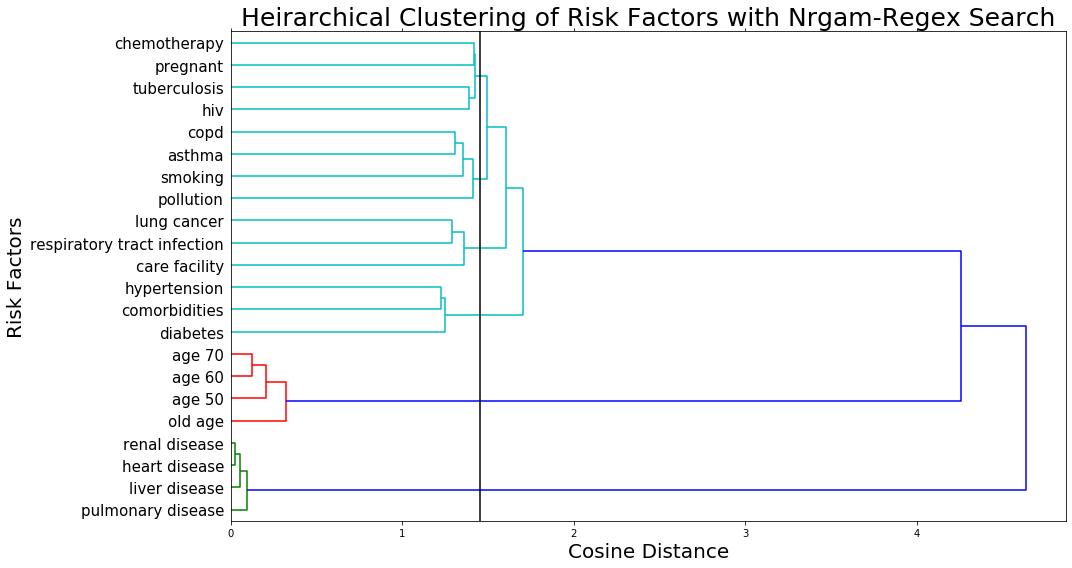

In [ ]:
plot_cluster_risk_factors_regex_tf, risk_factor_cluster_regex_df = heirarchical_clustering(risk_factors_tf_df, 
                                                                                           metric = 'cosine', 
                                                                                          cutoff_line = 1.45, 
                                                                                          title = 'Heirarchical Clustering of Risk Factors with Nrgam-Regex Search', 
                                                                                          xlabel = 'Cosine Distance', 
                                                                                          ylabel = 'Risk Factors')

In [ ]:
print('-------------- Sample cluster example ---------------------')
risk_factor_cluster_regex_df[risk_factor_cluster_regex_df['cluster_regex'] == 5]

-------------- Sample cluster example ---------------------


,label_name,cluster_regex
3,asthma,5
15,copd,5
17,pollution,5
18,smoking,5


## 4.2 - Using okapi BM25

In information retrieval, Okapi BM25 (BM stands for Best Matching) is a ranking function used by search engines to rank matching documents according to their relevance to a given search query. It is based on the probabilistic retrieval framework developed in the 1970s and 1980s by Stephen E. Robertson, Karen Spärck Jones, and others.

It assigns the documents a relavance score with respect to the query.

Source: https://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html

In [ ]:
#----- creating a corpus from the list of title and abstract merged and creating the tokens -------------------------------------------------------------------------------------

corpus_paper = df_papers['title_abstract_merged_cleaned'].to_list() 
tokenized_corpus_paper = [doc.split(" ") for doc in corpus_paper]

risk_factors_bm25_matrix = pd.DataFrame()
bm25 = BM25Okapi(tokenized_corpus_paper)

for i in risk_factor_count_num_cutoff.index:
    
    query = i
    tokenized_query = query.split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    risk_factors_bm25_matrix[i] = doc_scores

In [ ]:
risk_factors_bm25_matrix.head()

,respiratory tract infection,hiv,pulmonary disease,asthma,tuberculosis,liver disease,old age,diabetes,pregnant,age 50,...,comorbidities,hypertension,age 60,copd,renal disease,pollution,smoking,chemotherapy,lung cancer,age 70
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,1.113088,0.0,0.0,1.113088,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.113088,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.292451,0.0,0.927577,0.0,0.0,0.927577,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.927577,0.0,0.0,0.0,0.0,0.0


### Initiating hierarchichal clustering

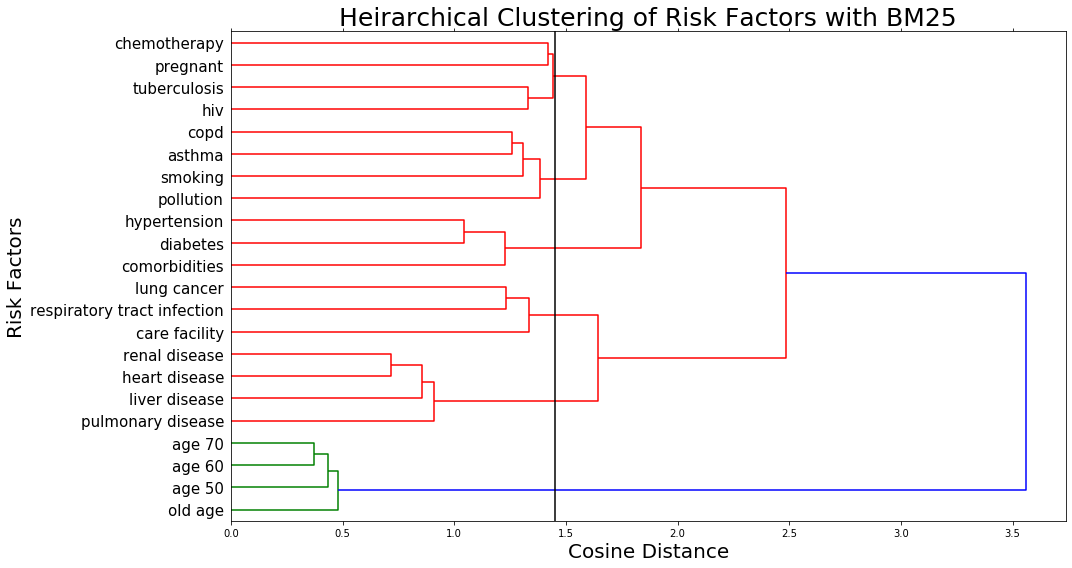

In [ ]:
plot_cluster_risk_factors_bm25, risk_factor_cluster_bm25_df = heirarchical_clustering(risk_factors_bm25_matrix, 
                                                                                      metric = 'cosine', 
                                                                                      cutoff_line = 1.45, 
                                                                                  title = 'Heirarchical Clustering of Risk Factors with BM25', 
                                                                                  xlabel = 'Cosine Distance', 
                                                                                  ylabel = 'Risk Factors')

In [ ]:
print('-------------- Sample cluster example ---------------------')
risk_factor_cluster_bm25_df[risk_factor_cluster_bm25_df['cluster_regex'] == 5]

-------------- Sample cluster example ---------------------


,label_name,cluster_regex
3,asthma,5
15,copd,5
17,pollution,5
18,smoking,5


## 4.3 - Using TFIDF - Vectorizer

Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

Source: http://www.tfidf.com/

In [ ]:
risk_factor_ngrams_model = TfidfVectorizer(ngram_range=(1,4), vocabulary=risk_factor_count_num_cutoff.index, use_idf=True)
risk_factors_ngrams_df = risk_factor_ngrams_model.fit_transform(df_papers['title_abstract_merged_cleaned'])
risk_factors_ngrams_matrix = pd.DataFrame(np.round(risk_factors_ngrams_df.toarray(), 4), columns = risk_factor_ngrams_model.get_feature_names())

In [ ]:
risk_factors_ngrams_matrix.head()

,respiratory tract infection,hiv,pulmonary disease,asthma,tuberculosis,liver disease,old age,diabetes,pregnant,age 50,...,comorbidities,hypertension,age 60,copd,renal disease,pollution,smoking,chemotherapy,lung cancer,age 70
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


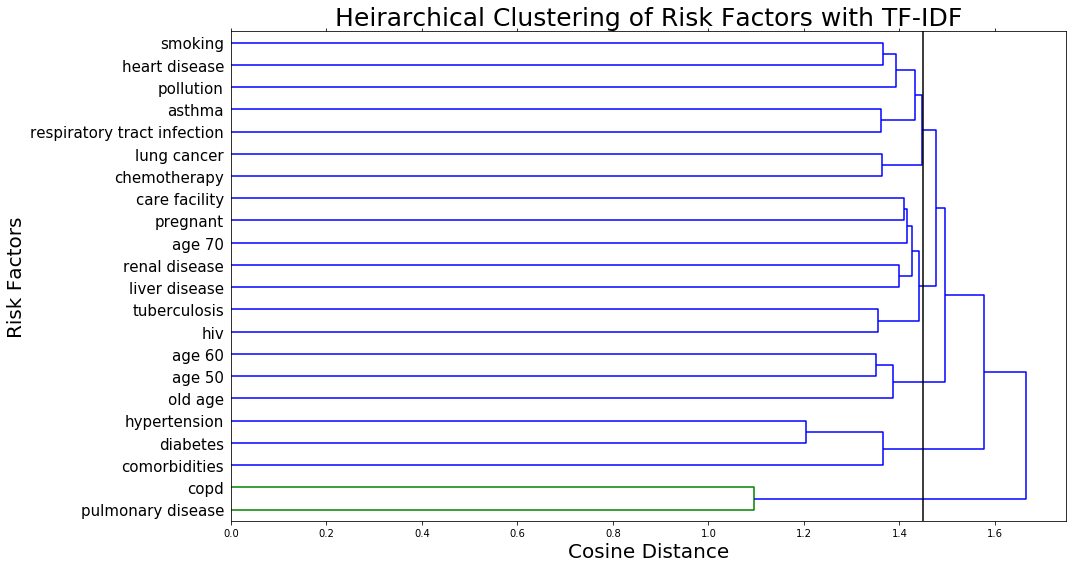

In [ ]:
plot_cluster_risk_factors_tfidf, risk_factor_cluster_tfidf_df = heirarchical_clustering(risk_factors_ngrams_matrix, 
                                                                                        metric = 'cosine', 
                                                                                      cutoff_line = 1.45, 
                                                                                      title = 'Heirarchical Clustering of Risk Factors with TF-IDF', 
                                                                                      xlabel = 'Cosine Distance', 
                                                                                      ylabel = 'Risk Factors')

In [ ]:
print('-------------- Sample cluster example ---------------------')
risk_factor_cluster_tfidf_df[risk_factor_cluster_tfidf_df['cluster_regex'] == 5]

-------------- Sample cluster example ---------------------


,label_name,cluster_regex
0,respiratory tract infection,5
3,asthma,5
10,heart disease,5
17,pollution,5
18,smoking,5
19,chemotherapy,5
20,lung cancer,5


## Observation:

**Based on the 3 types of clustering done above on Risk Factors**

### 1. Modified Bag of Ngrams using REGEX
The clusters obatained were fairly coherent and the algorith was able to club similar risk factors together. (as expected based on online information available and Research Paper context). Eg. the cluster 5 comprises of all the breathing related risk factors such as asthma, copd,  pollution and smoking. Hence the **performace** of the clustering model was **good**.

### 2. Okapi BM25
The clusters obtained were similar to that of Modified Bag of Ngrams using REGEX, and the cluster 5 had all the same components of breathing related risk factors as mentioned in the previous point. Hence the **performace** of the BM25 clustering model was **good**. 

### 3. TFIDF - Vectorizer
The clustering with TFIDF was poorly executed. The risk factors related to breathing in cluster 5 were hampered with the outliers like heart disease and chemotherapy. The poor performance can be attributed to the fact that tfidf is searching for the token of the ngram labels as they are mentioned in the list, in an ordered way. There is no similarity drawn based on the fact that the tokens of the labels might exist in the document independently. Hence the **performace** of the TFIDF clustering model was **bad**. 


## Conclusion:
Based on the discussion above, Modified Bag of Ngrams using REGEX and Okapi BM25 seem to be the best dataframe creation models to generate coherent and meaningful clusters. For the purpose of choosing a single model in this notebook, **we will go ahead with the Modified Bag of Ngrams using REGEX** dataframe creation model since the clusters obtained consider the term frequency of all the tokens in a ngram label in the abstract.

# 5. EXPERIMENTING DIFFERENT DATAFRAMES MODEL OF RISK FACTORS LABELS FOR KMEANS CLUSTERING -----------------------------------------------------------

**K-means** clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. It is popular for cluster analysis in data mining. k-means clustering minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances, which would be the more difficult Weber problem: the mean optimizes squared errors, whereas only the geometric median minimizes Euclidean distances. For instance, Better Euclidean solutions can be found using k-medians and k-medoids.

Source: https://en.wikipedia.org/wiki/K-means_clustering

## 5.1. Kmeans on Modified Bag of Ngrams using REGEX On Risk Factors (self developed)

In [ ]:
risk_factor_cluster_regex_kmeans_df = kmeans_clustering(risk_factors_tf_df, n_clusters=6)

In [ ]:
print('-------------- Sample cluster example ---------------------')
risk_factor_cluster_regex_kmeans_df[risk_factor_cluster_regex_kmeans_df['cluster_regex'] == 2]

-------------- Sample cluster example ---------------------


,label_name,cluster_regex
0,respiratory tract infection,2


## 5.2. Kmeans on okapi BM25

In [ ]:
risk_factor_cluster_bm25_kmeans_df = kmeans_clustering(risk_factors_bm25_matrix, n_clusters=6)

In [ ]:
print('-------------- Sample cluster example ---------------------')
risk_factor_cluster_bm25_kmeans_df[risk_factor_cluster_bm25_kmeans_df['cluster_regex'] == 2]

-------------- Sample cluster example ---------------------


,label_name,cluster_regex
3,asthma,2
4,tuberculosis,2
7,diabetes,2
8,pregnant,2
11,care facility,2
12,comorbidities,2
13,hypertension,2
15,copd,2
17,pollution,2
18,smoking,2


## 5.3. Kmeans on TFIDF - Vectorizer

In [ ]:
risk_factor_cluster_tfidf_kmeans_df = kmeans_clustering(risk_factors_ngrams_matrix, n_clusters=6)

In [ ]:
print('-------------- Sample cluster example ---------------------')
risk_factor_cluster_tfidf_kmeans_df[risk_factor_cluster_tfidf_kmeans_df['cluster_regex'] == 2]

-------------- Sample cluster example ---------------------


,label_name,cluster_regex
0,respiratory tract infection,2


## Observation:

**Based on the 3 types of clustering done above on Risk Factors on Kmeans**

Kmeans has **resulted in incoherent and inconsistent clusters**. Hence we will **not use Kmeans** and **will proceed with Hierarchical Clustering with Modified Bag of Ngrams using REGEX dataframe creation model**

# 6. HIERARCHICAL CLUSTERING OF RISK FACTORS -----------------------------------

#### A repetition of section 4.1 placed here to maintain a coherent flow of the notebook


### Section 4.1 - Modified Bag of Ngrams using REGEX On Risk Factors (self developed)

#### WORKING:
- Each label with ngrams would be splitted into tokens
- Each token would be searched in each abstract to fetch a count of the appearance of the token in each abstract
- Each count of each tokens would be added
- The sum of each tokens appearance would then we divided by the total words in abstract (to normalise)

#### OUTPUT:
- This would give us combined frequency of the bag of words which is similar to coneventional bag of words frequency but has been modified to search for work tokens from the labels, which appear in any order in the text condsidered
- The vectors of each label obtained by this method would then be used for clustering.

### NOTE: The full function has been modelled in Section 0 to keep the code concise

In [ ]:
risk_factors_tf_df = regex_ngram_term_frequency(risk_factor_count_num_cutoff, df_papers, 
                                                search_column = 'title_abstract_merged_cleaned')

In [ ]:
risk_factors_tf_df.head()

,respiratory tract infection,hiv,pulmonary disease,asthma,tuberculosis,liver disease,old age,diabetes,pregnant,age 50,...,comorbidities,hypertension,age 60,copd,renal disease,pollution,smoking,chemotherapy,lung cancer,age 70
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.042553,0.0,0.0,0.042553,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.042553,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.006329,0.0,0.018987,0.0,0.0,0.018987,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.018987,0.0,0.0,0.0,0.0,0.0


### Initiating hierarchichal clustering
The following code produces and plots the clusters using the reduced risk factors list. The vectors extracted from Ngrams were made into a distance matrix using cosine distance metric. Further Dendograms were made to analyse

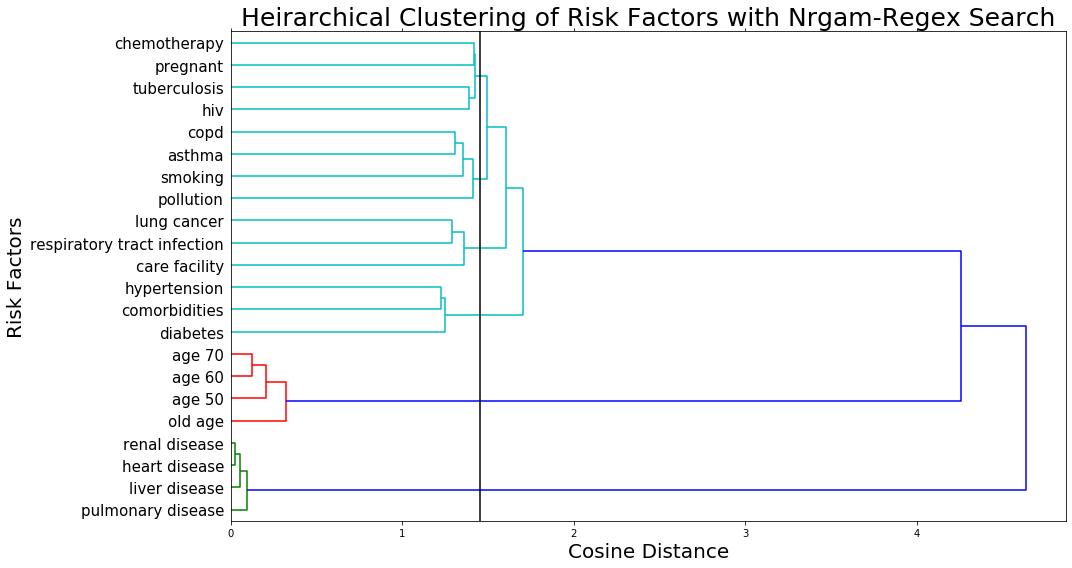

In [ ]:
plot_cluster_risk_factors_regex_tf, risk_factor_cluster_regex_df = heirarchical_clustering(risk_factors_tf_df, metric = 'cosine', 
                                                                                  cutoff_line = 1.45, 
                                                                                  title = 'Heirarchical Clustering of Risk Factors with Nrgam-Regex Search', 
                                                                                  xlabel = 'Cosine Distance', 
                                                                                  ylabel = 'Risk Factors')

In [ ]:
print('-------------- Sample cluster example ---------------------')
risk_factor_cluster_regex_df[risk_factor_cluster_regex_df['cluster_regex'] == 5]

-------------- Sample cluster example ---------------------


,label_name,cluster_regex
3,asthma,5
15,copd,5
17,pollution,5
18,smoking,5


# 7. HIERARCHICAL CLUSTERING OF TRANSMISSION FACTORS -------------------

In [ ]:
transmission_factors_tf_df = regex_ngram_term_frequency(transmission_count_num_cutoff, df_papers, 
                                                search_column = 'title_abstract_merged_cleaned')

In [ ]:
transmission_factors_tf_df.head()

,human transmission,environment,patient transmission,air,airborne,aerosol,mouth,close contact,droplet,respiratory route,respiratory secretion,direct contact,surface transmission,person contact,respiratory droplet,hand transmission
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,0.031915,0.0,0.010638,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.010638,0.0,0.0,0.010638
2,0.006452,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.006757,0.000000,0.0,0.0,0.000000
4,0.063291,0.0,0.063291,0.0,0.0,0.0,0.006329,0.0,0.0,0.0,0.0,0.018987,0.063291,0.0,0.0,0.063291


### Initiating hierarchichal clustering

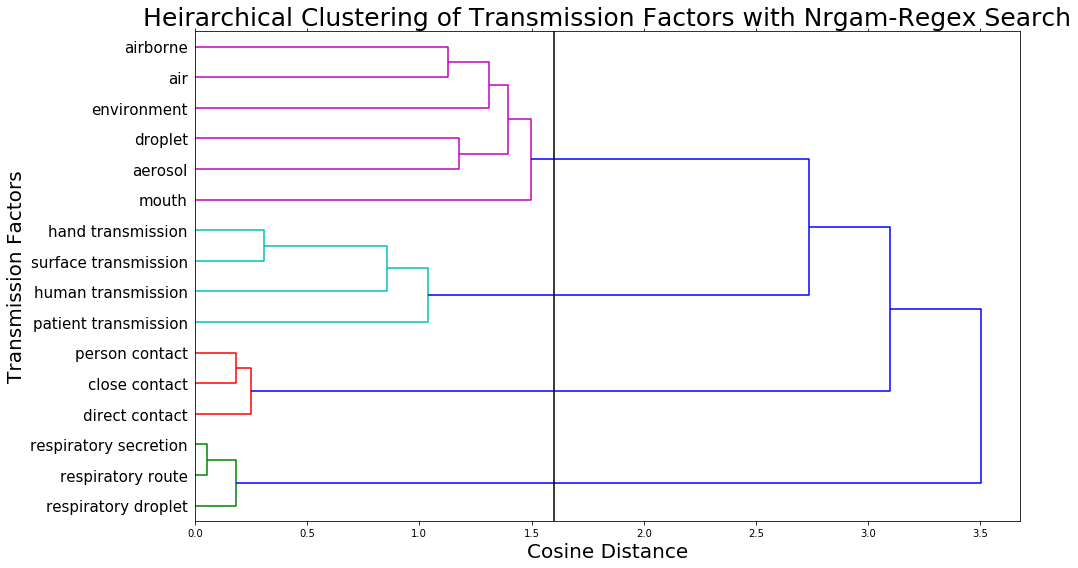

In [ ]:
plot_cluster_transmission_factors_regex_tf, transmission_factors_cluster_regex_df = heirarchical_clustering(transmission_factors_tf_df, metric = 'cosine', 
                                                                                  cutoff_line = 1.6, 
                                                                                  title = 'Heirarchical Clustering of Transmission Factors with Nrgam-Regex Search', 
                                                                                  xlabel = 'Cosine Distance', 
                                                                                  ylabel = 'Transmission Factors')

In [ ]:
print('-------------- Sample cluster example ---------------------')
transmission_factors_cluster_regex_df[transmission_factors_cluster_regex_df['cluster_regex'] == 4]

-------------- Sample cluster example ---------------------


,label_name,cluster_regex
1,environment,4
3,air,4
4,airborne,4
5,aerosol,4
6,mouth,4
8,droplet,4


# 8. HIERARCHICAL CLUSTERING OF AFFECTED ORGANS ---------------------------

In [ ]:
organs_tf_df = regex_ngram_term_frequency(organs_count_num_cutoff, df_papers, 
                                                search_column = 'title_abstract_merged_cleaned')

In [ ]:
organs_tf_df.head()

,lung,respiratory system,liver,brain,kidney,nervous system,heart,spleen,skin,lymph node,mouth,bone marrow,eye,small intestine,trachea
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.010638,0.0,0.0,0.0,0.010638,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.006329,0.0,0.0,0.0,0.0


### Initiating hierarchichal clustering

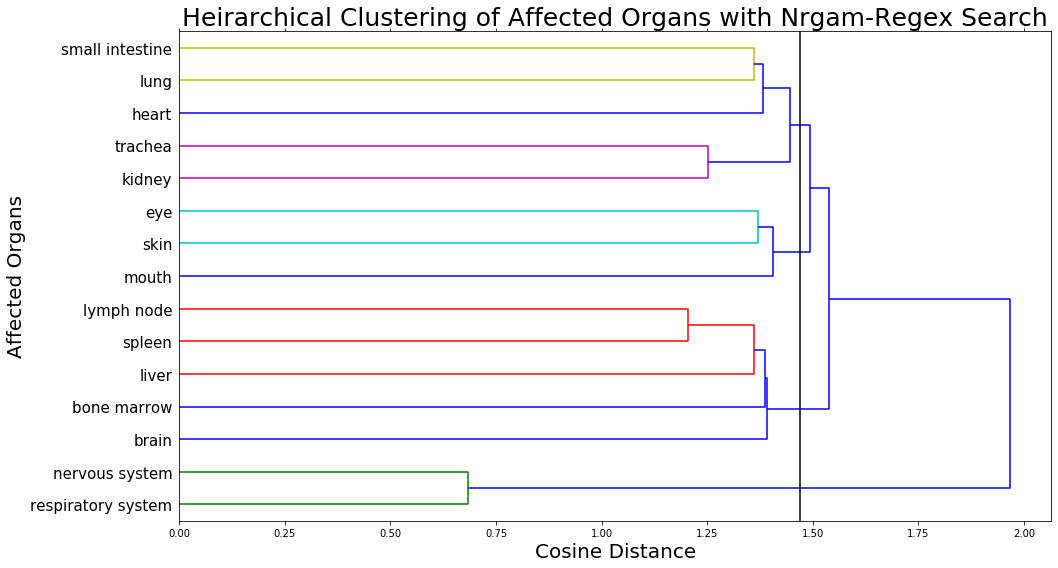

In [ ]:
plot_cluster_organs_regex_tf, organs_cluster_regex_df = heirarchical_clustering(organs_tf_df, metric = 'cosine', 
                                                                                  cutoff_line = 1.47, 
                                                                                  title = 'Heirarchical Clustering of Affected Organs with Nrgam-Regex Search', 
                                                                                  xlabel = 'Cosine Distance', 
                                                                                  ylabel = 'Affected Organs')

In [ ]:
print('-------------- Sample cluster example ---------------------')
organs_cluster_regex_df[organs_cluster_regex_df['cluster_regex'] == 4]

-------------- Sample cluster example ---------------------


,label_name,cluster_regex
0,lung,4
4,kidney,4
6,heart,4
13,small intestine,4
14,trachea,4


# 9. INSIGHTS AND RESULTS SUMMARY ------------------------------------------------------

## 9.1. Summary of Coding Logic and Experimentation with Clustering
(Section wise summary)

#### Section 0. LIBRARIES
    All the functions were defined, and necessary libraries loaded
    
#### Section 1. DATA PREPARATION 
    The Abstract was merged with the Title, to expand the research parameters. Furthermore, the data was cleaned accordingly to serve the purpose of NGram searching and Dataframe creation of bag of words frequencies.  Also, the year of publish column was created
    
#### Section 2.	SEARCHING LABELS
    A novel method was developed to search for the labels by splitting the label into tokens, and taking the intersection of the outputs of each token search. This would ensure that all the tokens of the label appeared in a abstract selected (irrespective of the order of tokens)
    
#### Section 3. DATA EXPLORATION
    Data was explored and the labels appearing in more than 100 papers were chosen and rest were dropped. Including the frequency bar chart and time series of risk factors, transmission factors and affected organs
    
#### Section 4. EXPERIMENTING DIFFERENT DATAFRAMES MODEL OF RISK FACTORS LABELS FOR HEIRARCHICAL CLUSTERING
    The 3 types of dataframe creation techniques were explored (Modified Bag of Ngrams using REGEX | okapi BM25 | TFIDF – Vectorizer) and expirimented upon hierarchical clustering. From that, the best output was obtained with Modified Bag of Ngrams using REGEX.
    
#### Section 5. EXPERIMENTING DIFFERENT DATAFRAMES MODEL OF RISK FACTORS LABELS FOR KMEANS CLUSTERING
    The 3 types of dataframe creation techniques were explored (Modified Bag of Ngrams using REGEX | okapi BM25 | TFIDF – Vectorizer) and expirimented upon KMeans clustering. From that, none of the model performance was satisfactory and hence idea of using Kmeans was dropped.
    
#### Section 6.	HIERARCHICAL CLUSTERING OF RISK FACTORS
    With the best results as per the section 4 experiment, hierarchical clustering was performed on Risk Factors using Modified Bag of Ngrams using REGEX.(obainted after dropping the labels with less than 100 count in section 3 of data exploration.) 

#### Section 7.	HIERARCHICAL CLUSTERING OF TRANSMISSION FACTORS
    Similar to the previous section, hierarchical clustering was performed on Transmission Factors using Modified Bag of Ngrams using REGEX.

#### Section 8.	HIERARCHICAL CLUSTERING OF AFFECTED ORGANS
    Similar to the previous section, hierarchical clustering was performed on Affected Organs using Modified Bag of Ngrams using REGEX.

## 9.2 Summary of Data Visualization and Inferred Results

## 9.2.1 Risk Factors

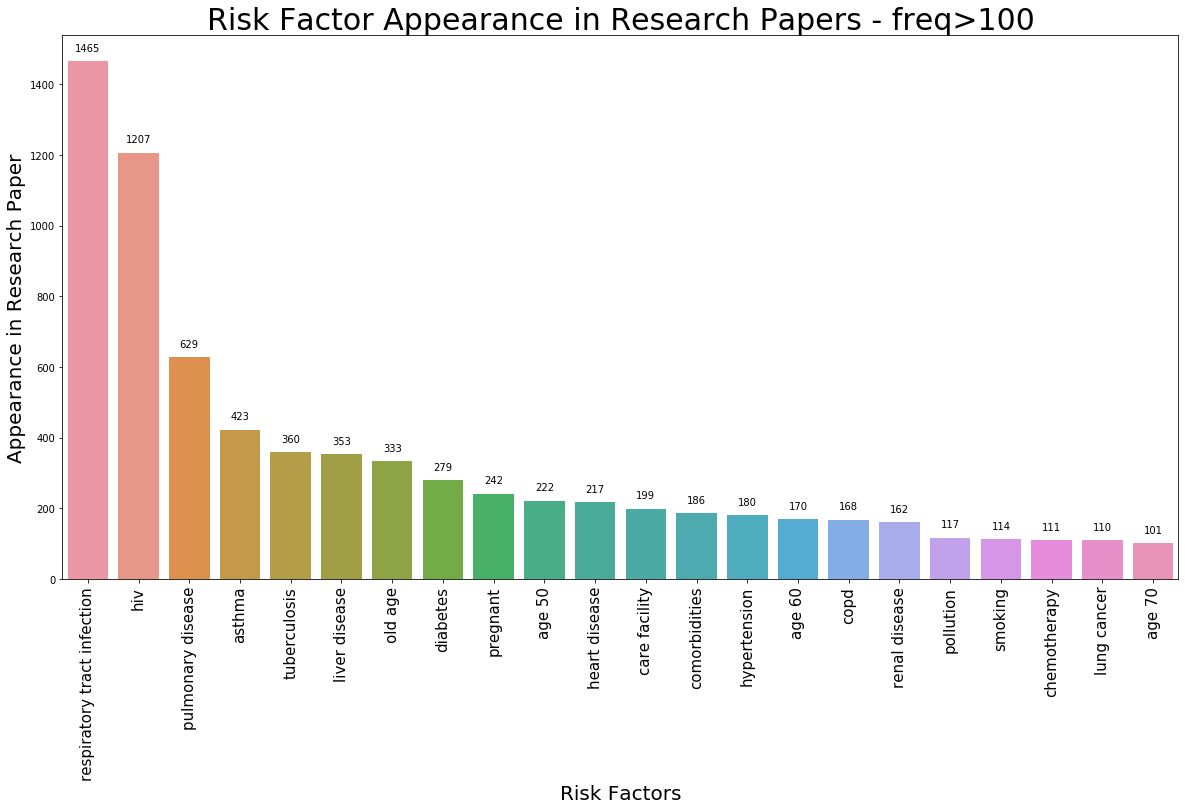

In [ ]:
plot_barplot(x = risk_factor_count_num_cutoff.index, y = risk_factor_count_num_cutoff.values, 
                 title = 'Risk Factor Appearance in Research Papers - freq>100', 
                 xlabel = 'Risk Factors', 
                 ylabel = 'Appearance in Research Paper', 
                 figsize=(20,10), t_size = 30, x_size = 20, y_size = 20, xticks_size = 15)

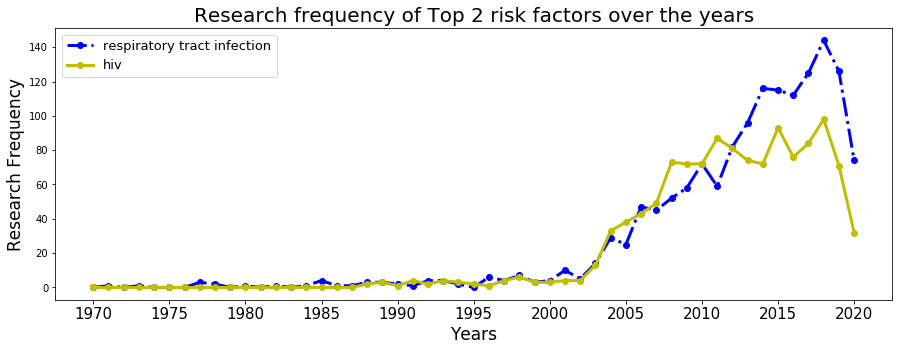

In [ ]:
#----- plotting the time series of top 2 risk factors -------------------------------------------------------------------------

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.subplot(1,1,1)
plt.plot(first_risk_factor_df.index, first_risk_factor_df.values, marker='o', color='b', linestyle='-.', linewidth=3, label = risk_factor_count_num_cutoff.index[0])
plt.plot(second_risk_factor_df.index, second_risk_factor_df.values,marker='o', color='y', linewidth=3, label = risk_factor_count_num_cutoff.index[1])
plt.xticks(np.arange(1970,2025,5), rotation=0, fontsize=15)
plt.xlabel('Years', fontsize=17)
plt.ylabel('Research Frequency', fontsize=17)
plt.title('Research frequency of Top 2 risk factors over the years', fontsize=20)

plt.legend(fontsize=13)
plt.show()

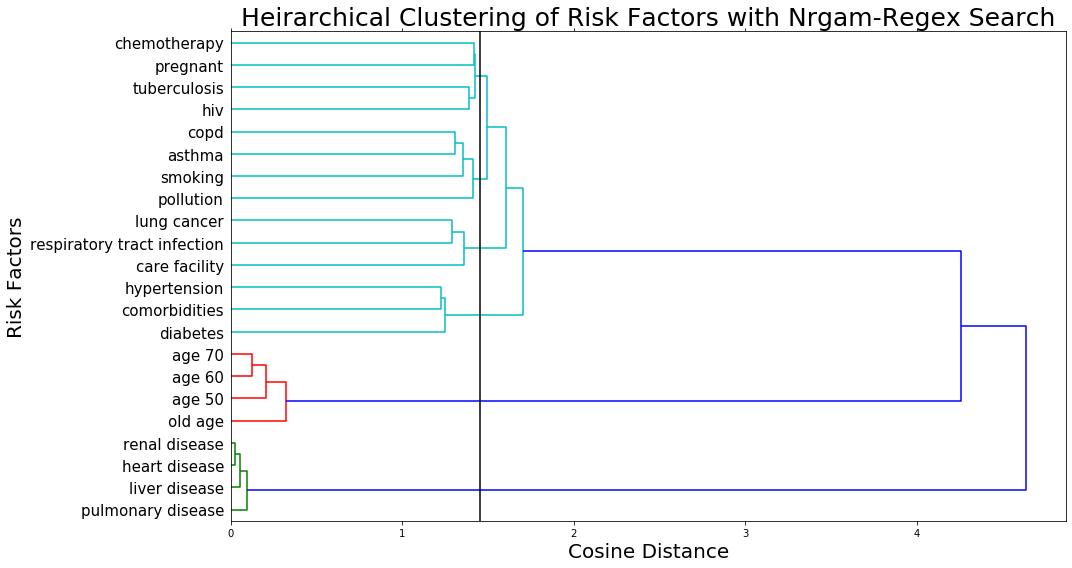

In [ ]:
plot_cluster_risk_factors_regex_tf, risk_factor_cluster_regex_df = heirarchical_clustering(risk_factors_tf_df, metric = 'cosine', 
                                                                                  cutoff_line = 1.45, 
                                                                                  title = 'Heirarchical Clustering of Risk Factors with Nrgam-Regex Search', 
                                                                                  xlabel = 'Cosine Distance', 
                                                                                  ylabel = 'Risk Factors')

In [ ]:
for i in range(1,len(risk_factor_cluster_regex_df['cluster_regex'].unique())+1):
    print('--------------------------------------------------------------------------')
    print(risk_factor_cluster_regex_df[risk_factor_cluster_regex_df['cluster_regex'] == i], '\n')

--------------------------------------------------------------------------
           label_name  cluster_regex
2   pulmonary disease              1
5       liver disease              1
10      heart disease              1
16      renal disease              1 

--------------------------------------------------------------------------
   label_name  cluster_regex
6     old age              2
9      age 50              2
14     age 60              2
21     age 70              2 

--------------------------------------------------------------------------
       label_name  cluster_regex
7        diabetes              3
12  comorbidities              3
13   hypertension              3 

--------------------------------------------------------------------------
                     label_name  cluster_regex
0   respiratory tract infection              4
11                care facility              4
20                  lung cancer              4 

------------------------------------------

# Observation:

### Risk Factor Appearance in Research Paper:
It seems that the pre existing condition of respiratory track infection, HIV, Pulmonary Disease and Asthama are the major risk factors discussed in the research papers related to coronaviruses. Hence people with these pre-existing condiotions should be extra careful and under care during the corona virus pandemic.
Also, people with age 50 appear to be at most risk (age wise) during the pandemic. This figure corresponds to the data available on CDC and WHO website

### Research frequency of Top 2 Risk Factors: 
Also, in Risk Factor Time Series Graph, it is evident that the research of the risk factors of **HIV and Respiratory Track Infection** started growing after 2003. The reson being, **2003 was hit by one of a kind SARS pandemic** which is similar to the current coronavirus pandemic in terms of symptoms. Hence the research post the 2003 pandemic increased in weak immunity and breathing based risk factors such as HIV and Respiratory Track Infection.

### Heirarchical Clustering of Risk Factors & Discussion:
We see that:
- **cluster 1** is relates to risk factor associated with **preexisting conditions in organs** like liver, heart and renal (kidney)


- **cluster 2** is related to the risk factors associated with **the age** related immunity loss. Also, the graph of Risk Factor Appearance in Research Paper suggests that people in their 50's/old age are at highest risk in the COVID-19 pandemic


- **cluster 3** suggests that risk factors related to **obesity** such as diabetes, comorbidities and hypertension. The combined impact of diabetes and high blood pressure can increase the risk of cardiovascular disease, kidney disease, and other health problems in the COVID-19 Pandemic


- **cluster 4** suggests that risk factors related to **breathing complications** arising pre-existing conditions like lung cancer or RTI. Moreover working in a care facility for corona virus also puts one at risk of contracting the virus.


- **cluster 5** suggests that risk factors related to pre-existing condiotions of **air pollution** like pollution, smoking, asthma and COPD. Living in a polluted area or smoking will put one at higher risk during COVID pandemic


- **cluster 6** suggests that risk factors related to pre-existing condiotions of **weak immunity** due to HIV Aids, Tuberculosis, Pregnancy and Cheamotherapy.

# COVID Tackling Suggestions and Guidlines (based on above discussion):

1. People with pre-existing condition in organs like liver, heart and kidneys must be extra cautious about their well being in this pandemic and avoid consumption of fried food or alcohol.


2. During treatment, doctors and nurses for must be cautious about the medical history of the patient especially if he/she has liver/heart/kidney disease.


3. People must develop a care plan which summarizes your health conditions, medications, healthcare providers, emergency contacts, and end-of-life care options (for example, advance directives).


4. Older people must be cautious, especially the ones around the age group of 50.


5. Obesity puts people at higer risk of COVID and might add on complications in their treatment. Hence indoor excercise is very important during this pandemic


6. One must not smoke or stay in a polluted (air) environment for long as this will weaken your lung capacity and make you prone to COVID


7. People inherent or induced with weak immune system must stay home. Especially pregnant women and people with HIV or TB.


8. Cheamotherapy for cancer treatment potentially lowers immunity. Hence one should consult their doctor before going out for such treatment during the pandemic.

**9. Golden Rule: Social - Distancing** - Social distancing caters to all the points discussed above and will help decrease the spread


## 9.2.2 Transmission Factors

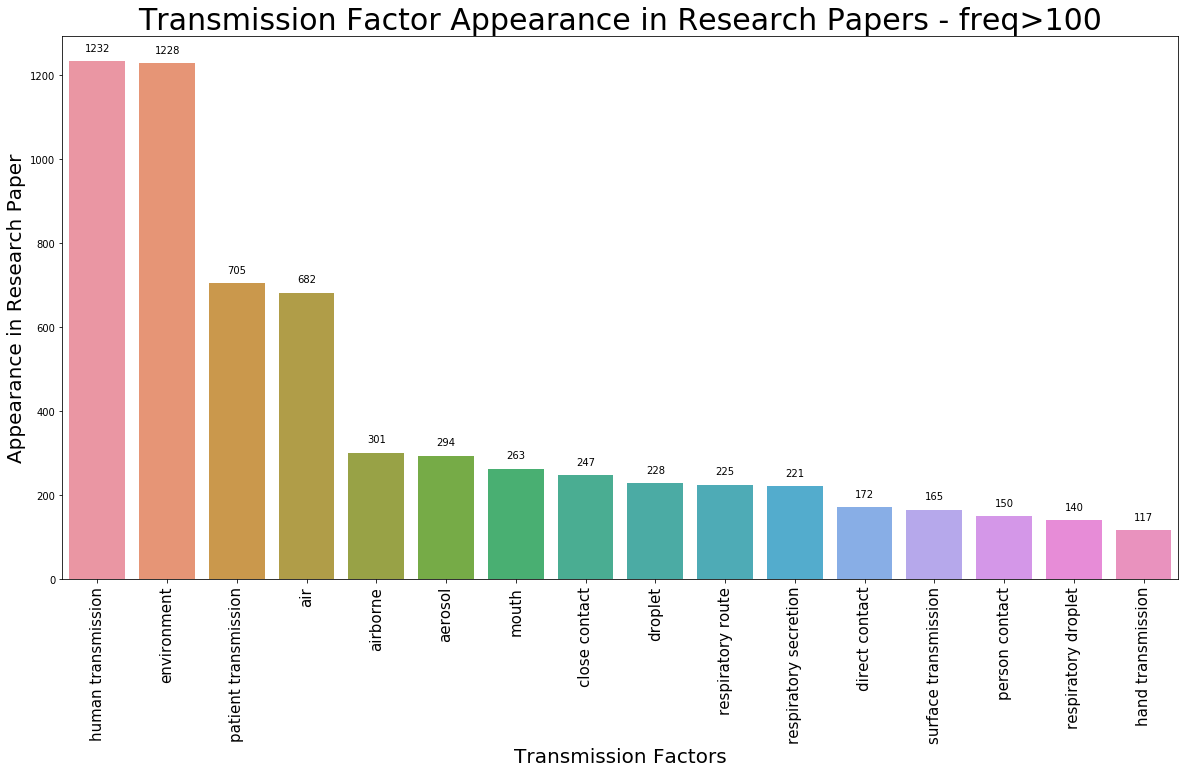

In [ ]:
plot_barplot(x = transmission_count_num_cutoff.index, y = transmission_count_num_cutoff.values, 
                 title = 'Transmission Factor Appearance in Research Papers - freq>100', 
                 xlabel = 'Transmission Factors', 
                 ylabel = 'Appearance in Research Paper', 
                 figsize=(20,10), t_size = 30, x_size = 20, y_size = 20, xticks_size = 15)

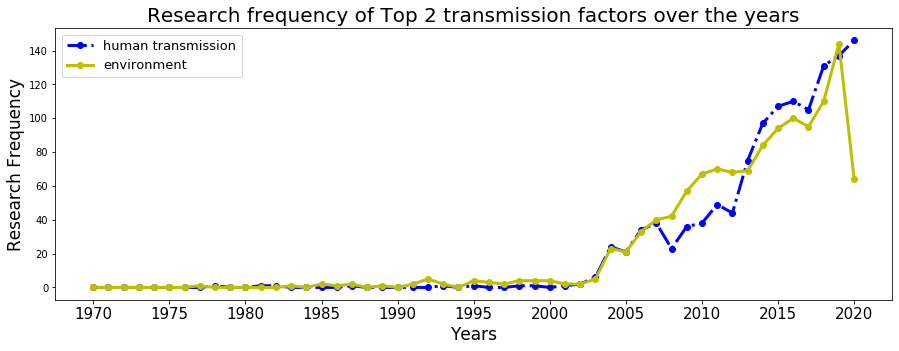

In [ ]:
#----- plotting the time series of top 2 transmission factors -------------------------------------------------------------------------

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.subplot(1,1,1)
plt.plot(first_transmission_factor_df.index, first_transmission_factor_df.values, marker='o', color='b', linestyle='-.', linewidth=3, label = transmission_count_num_cutoff.index[0])
plt.plot(second_transmission_factor_df.index, second_transmission_factor_df.values,marker='o', color='y', linewidth=3, label = transmission_count_num_cutoff.index[1])
plt.xticks(np.arange(1970,2025,5), rotation=0, fontsize=15)
plt.xlabel('Years', fontsize=17)
plt.ylabel('Research Frequency', fontsize=17)
plt.title('Research frequency of Top 2 transmission factors over the years', fontsize=20)

plt.legend(fontsize=13)
plt.show()

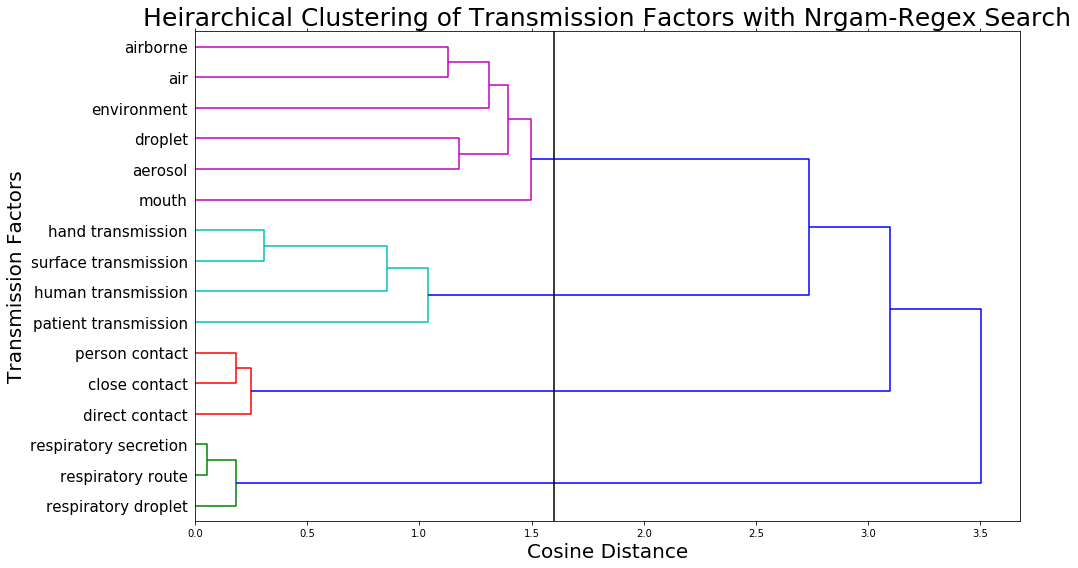

In [ ]:
plot_cluster_transmission_factors_regex_tf, transmission_factors_cluster_regex_df = heirarchical_clustering(transmission_factors_tf_df, metric = 'cosine', 
                                                                                  cutoff_line = 1.6, 
                                                                                  title = 'Heirarchical Clustering of Transmission Factors with Nrgam-Regex Search', 
                                                                                  xlabel = 'Cosine Distance', 
                                                                                  ylabel = 'Transmission Factors')

In [ ]:
for i in range(1,len(transmission_factors_cluster_regex_df['cluster_regex'].unique())+1):
    print('--------------------------------------------------------------------------')
    print(transmission_factors_cluster_regex_df[transmission_factors_cluster_regex_df['cluster_regex'] == i], '\n')

--------------------------------------------------------------------------
               label_name  cluster_regex
9       respiratory route              1
10  respiratory secretion              1
14    respiratory droplet              1 

--------------------------------------------------------------------------
        label_name  cluster_regex
7    close contact              2
11  direct contact              2
13  person contact              2 

--------------------------------------------------------------------------
              label_name  cluster_regex
0     human transmission              3
2   patient transmission              3
12  surface transmission              3
15     hand transmission              3 

--------------------------------------------------------------------------
    label_name  cluster_regex
1  environment              4
3          air              4
4     airborne              4
5      aerosol              4
6        mouth              4
8      droplet

# Observation:

### Transmission Factor Appearance in Research Paper:
**Human Transmission, Patient Transmission and air** appear to be most potent to spread coronaviruses. Hence **social distancing** during the pandemic would be an effective option to curb the spread of coronaviruses through such means.

### Research frequency of Top 2 Transmission Factors: 
Also, in **Transmission Factor Time Series Graph**, it is evident that the research of the transmission factors of Human Transmission and Environment **started growing after 2003**. The reson being, **2003 was hit by one of a kind SARS pandemic which could be spread between human-human and human-environemt surfaces** which is similar to the current coronavirus pandemic. Hence the research post the 2003 pandemic increased in transmission factors.

Moreover, in **Transmission Factor Time Series Graph**, the research of Transmission Factors hit its peak in 2019, which saw the onset of the coronavirus pandemic

### Heirarchical Clustering of Transmission Factors & Discussion:
We see that:
- **cluster 1** is relates to Transmission factor associated with **Air to Human (if in vicinity of an infected person)** through inhaling the respiratory droplets of an infected person.


- **cluster 2** is related to the Transmission factors associated with **Surface to Human**. Factors like direct contact with a surface having active virus might trigger the spread.


- **cluster 3** suggests that Transmission factors related to **Human to Human** contact. Handshakes or direct contact with a carrier of coronavirus will trigger the spread.


- **cluster 4** suggests that Transmission factors related to **Air to Human (airborne)** transmission. This cluster suggest the spread of the disease due to the inhaling the infected aerosol in the environment.  

# COVID Tackling Suggestions and Guidlines (based on above discussion):

1. Social Distancing must be practiced to avoid Air to Human (if in vicinity of an infected person) transmission.


2. During treatment, doctors and nurses must have protective equipment such as masks and gloves, so as to avoid transmission.


3. People should regularly wash their hands to avoid Surface to Human transmission.


4. Infected people must be isolated and caregivers must be protected to avoid human to human transmission.

## 9.2.3 Affected Organs

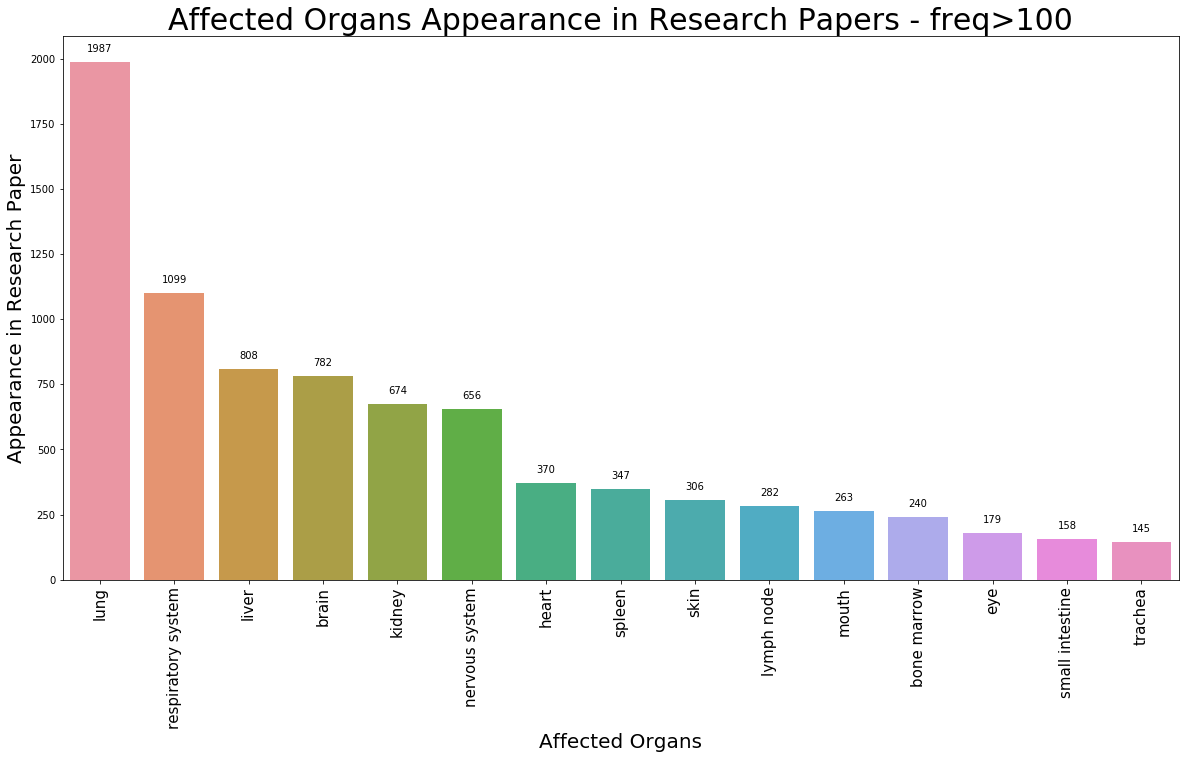

In [ ]:
plot_barplot(x = organs_count_num_cutoff.index, y = organs_count_num_cutoff.values, 
                 title = 'Affected Organs Appearance in Research Papers - freq>100', 
                 xlabel = 'Affected Organs', 
                 ylabel = 'Appearance in Research Paper', 
                 figsize=(20,10), t_size = 30, x_size = 20, y_size = 20, xticks_size = 15)

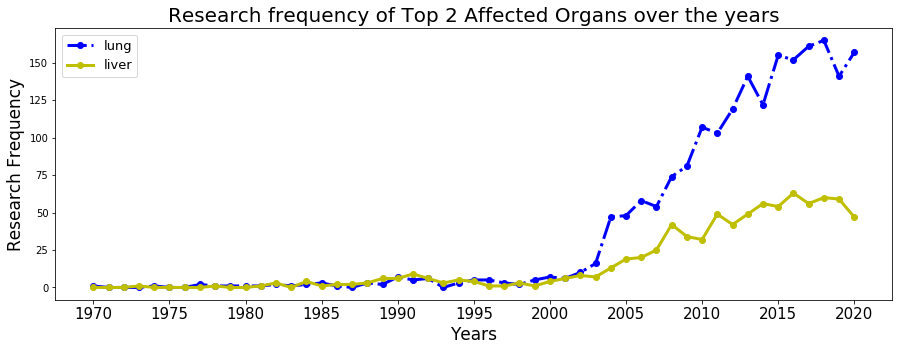

In [ ]:
#----- plotting the time series of top 2 affected organs -------------------------------------------------------------------------

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.subplot(1,1,1)
plt.plot(first_organ_df.index, first_organ_df.values, marker='o', color='b', linestyle='-.', linewidth=3, label = organs_count_num_cutoff.index[0])
plt.plot(second_organ_df.index, second_organ_df.values,marker='o', color='y', linewidth=3, label = organs_count_num_cutoff.index[2])
plt.xticks(np.arange(1970,2025,5), rotation=0, fontsize=15)
plt.xlabel('Years', fontsize=17)
plt.ylabel('Research Frequency', fontsize=17)
plt.title('Research frequency of Top 2 Affected Organs over the years', fontsize=20)

plt.legend(fontsize=13)
plt.show()

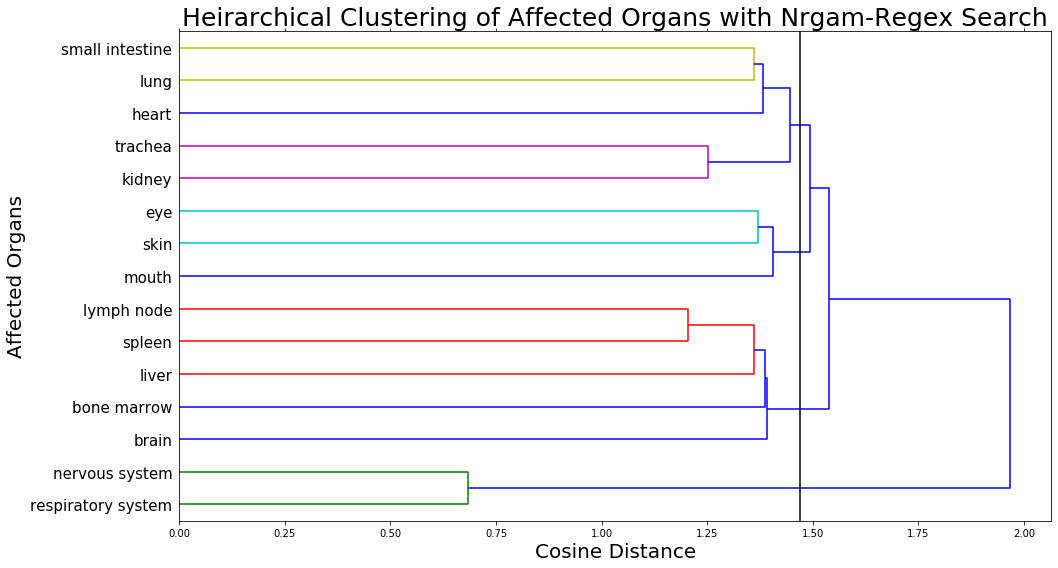

In [ ]:
plot_cluster_organs_regex_tf, organs_cluster_regex_df = heirarchical_clustering(organs_tf_df, metric = 'cosine', 
                                                                                  cutoff_line = 1.47, 
                                                                                  title = 'Heirarchical Clustering of Affected Organs with Nrgam-Regex Search', 
                                                                                  xlabel = 'Cosine Distance', 
                                                                                  ylabel = 'Affected Organs')

In [ ]:
for i in range(1,len(organs_cluster_regex_df['cluster_regex'].unique())+1):
    print('--------------------------------------------------------------------------')
    print(organs_cluster_regex_df[organs_cluster_regex_df['cluster_regex'] == i], '\n')

--------------------------------------------------------------------------
           label_name  cluster_regex
1  respiratory system              1
5      nervous system              1 

--------------------------------------------------------------------------
     label_name  cluster_regex
2         liver              2
3         brain              2
7        spleen              2
9    lymph node              2
11  bone marrow              2 

--------------------------------------------------------------------------
   label_name  cluster_regex
8        skin              3
10      mouth              3
12        eye              3 

--------------------------------------------------------------------------
         label_name  cluster_regex
0              lung              4
4            kidney              4
6             heart              4
13  small intestine              4
14          trachea              4 



# Observation:

### Affected Organs Appearance in Research Paper:
The coronaviruses seems to be affecting the **lungs, liver and kidney** the most. Hence care must be taken during organ transplant, **smoking and consumption of fried food and alcohol should be avoided** during this pandemic so as to avoid hampering the health of these organs

### Research frequency of Top 2 Affected Organs: 
Also, in **Affected Organ Time Series Graph**, it is evident that the research of the transmission factors of affected lungs and liver **started growing after 2003**. The reson being, **2003 was hit by one of a kind SARS pandemic which could affect the Lungs and Liver siverely** which is similar to the current coronavirus pandemic. Hence the research post the 2003 pandemic increased in such affected organs.

### Heirarchical Clustering of Affected Organs & Discussion:
We see that:
- **cluster 1** is relates to damage to the **respiratory system**.


- **cluster 2** is related to the damage associated with **liver and linked organs**. The bone marrow is the source of mature liver cells and spleen is affected due to the operation of the liver.


- **cluster 3** is related to the damage to the human body due to transmission with **eye or mouth** contact.


- **cluster 4** is related to the damage associated with **lung and linked organs**. Bad lung can hamper the functioning of kidneys and make heart irratic.

# Comparison with online information about COVID-19

The derived guidlines matches with the information available online regarding tackling COVID-19 pandemic